# Predicting Future Electrification Needs

## Import libraries  and Packages
Here is the section to import all the packages/libraries that will be used through this notebook.

In [2]:
# data handling
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Vizualisation (Matplotlib, Plotly, Seaborn, etc. )
import seaborn as sns
import matplotlib.pyplot as plt

# Imputation
from miceforest import ImputationKernel

# Feature Processing (Scikit-learn processing, etc. )
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer

# Machine Learning models
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

# Evaluation and error metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score, make_scorer

import os, joblib

## Data Loading

In [3]:
electricity_df = pd.read_csv('Electricity Dataset/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_240346.csv', skiprows=4)
Country_Meta = pd.read_csv('Electricity Dataset/Metadata_Country_API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_240346.csv')
population_df = pd.read_excel('Additional data/API_SP.POP.TOTL_DS2_en_excel_v2_228830.xls', "Data", header = 3)
gdp_df = pd.read_excel('Additional data/API_NY.GDP.PCAP.CD_DS2_en_excel_v2_242527.xls', "Data", header = 3)
cpi_df = pd.read_excel('Additional data/API_FP.CPI.TOTL.ZG_DS2_en_excel_v2_240677.xls', "Data", header = 3)
consumption_df = pd.read_excel('Additional data/API_EG.USE.ELEC.KH.PC_DS2_en_excel_v2_228175.xlsx', "Data", header = 3)

## Data Understanding & Preparation

### Electricity Dataset

In [4]:
electricity_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,99.153656,99.197128,99.239914,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,91.660398,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,93.356292,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.957302,19.975365,21.576500,22.529265,23.749531,23.493013,25.191221,26.807937,25.943316,26.193895,27.400110,28.914348,31.666928,31.695183,31.859257,33.903515,38.851444,40.197332,43.028332,44.389773,46.268621,48.103609,NaN,NaN,NaN
2,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.400000,48.279007,42.700000,43.222019,69.100000,68.040878,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000,NaN,NaN,NaN
3,Africa Western and Central,AFW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.575130,32.609692,33.605668,32.629322,32.461797,33.45863,34.810428,34.137971,35.232691,35.722926,39.824589,37.493058,37.792163,39.818819,40.764345,41.741152,41.871043,41.839309,45.911036,44.053700,47.051990,47.647405,46.758948,50.903108,48.787640,51.212863,51.160817,51.734388,54.224187,NaN,NaN,NaN
4,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.238865,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.490000,33.846977,34.980053,34.600000,37.259491,38.398178,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854,NaN,NaN,NaN


In [5]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 69 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

In [6]:
# drop null columns by index
columns_to_drop = electricity_df.columns[4:34]  # Columns from 1960 to 1989
electricity_df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Drop more unwanted columns
columns_to_drop =['Unnamed: 68',"Indicator Name", "Indicator Code", "2023"]
electricity_df.drop(columns=columns_to_drop, inplace=True)

In [8]:
electricity_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,100.0,99.153656,99.197128,99.239914,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,91.660398,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,93.356292,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.957302,19.975365,21.576500,22.529265,23.749531,23.493013,25.191221,26.807937,25.943316,26.193895,27.400110,28.914348,31.666928,31.695183,31.859257,33.903515,38.851444,40.197332,43.028332,44.389773,46.268621,48.103609,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.446891,9.294527,14.133616,18.971165,23.814182,28.669672,33.544418,38.440002,42.400000,48.279007,42.700000,43.222019,69.100000,68.040878,89.500000,71.500000,97.700000,97.700000,93.430878,97.700000,97.700000,97.700000,NaN
3,Africa Western and Central,AFW,NaN,NaN,NaN,31.575130,32.609692,33.605668,32.629322,32.461797,33.45863,34.810428,34.137971,35.232691,35.722926,39.824589,37.493058,37.792163,39.818819,40.764345,41.741152,41.871043,41.839309,45.911036,44.053700,47.051990,47.647405,46.758948,50.903108,48.787640,51.212863,51.160817,51.734388,54.224187,NaN
4,Angola,AGO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.238865,20.000000,26.320255,27.355137,28.395485,29.448309,30.520388,37.500000,38.490000,33.846977,34.980053,34.600000,37.259491,38.398178,32.000000,42.000000,41.785034,42.906242,45.290000,45.633881,46.955444,48.223854,NaN


In [9]:
# Fill in 2022 null values with ffill
electricity_df['2022'] = electricity_df['2021']

In [10]:
electricity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  266 non-null    object 
 1   Country Code  266 non-null    object 
 2   1990          108 non-null    float64
 3   1991          118 non-null    float64
 4   1992          135 non-null    float64
 5   1993          150 non-null    float64
 6   1994          156 non-null    float64
 7   1995          164 non-null    float64
 8   1996          177 non-null    float64
 9   1997          184 non-null    float64
 10  1998          193 non-null    float64
 11  1999          202 non-null    float64
 12  2000          259 non-null    float64
 13  2001          259 non-null    float64
 14  2002          260 non-null    float64
 15  2003          260 non-null    float64
 16  2004          260 non-null    float64
 17  2005          260 non-null    float64
 18  2006          260 non-null    

In [11]:
# Melt DataFrame to convert it from wide to long format
melted_df = pd.melt(electricity_df, id_vars=['Country Name', 'Country Code'],
                    var_name='Year', value_name='Access to electricity (% of population)')

melted_df['Year'] = pd.to_numeric(melted_df['Year'])

melted_df.head(10)

,Country Name,Country Code,Year,Access to electricity (% of population)
0,Aruba,ABW,1990,100.0000
1,Africa Eastern and Southern,AFE,1990,NaN
2,Afghanistan,AFG,1990,NaN
3,Africa Western and Central,AFW,1990,NaN
4,Angola,AGO,1990,NaN
5,Albania,ALB,1990,100.0000
6,Andorra,AND,1990,100.0000
7,Arab World,ARB,1990,NaN
8,United Arab Emirates,ARE,1990,100.0000
9,Argentina,ARG,1990,92.1548


In [12]:
melted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 4 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Country Name                             8778 non-null   object 
 1   Country Code                             8778 non-null   object 
 2   Year                                     8778 non-null   int64  
 3   Access to electricity (% of population)  7611 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 274.4+ KB


In [13]:
# View Unique countries/regions in 'Country Name' Column

Countries = melted_df['Country Name'].unique()

print(f'Unique countries in the electricity data are {Countries.size}')
Countries

Unique countries in the electricity data are 266


array(['Aruba', 'Africa Eastern and Southern', 'Afghanistan',
       'Africa Western and Central', 'Angola', 'Albania', 'Andorra',
       'Arab World', 'United Arab Emirates', 'Argentina', 'Armenia',
       'American Samoa', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas, The',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Central Europe and the Baltics', 'Switzerland', 'Channel Islands',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Caribbean small states', 'Cuba', 'Curacao', 'Cayman Islands',
       'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark',
       'Dominican Republic', 'Algeria',
 

In [14]:
# Change onject dtypes to category
melted_df['Country Name'] = melted_df['Country Name'].astype('category')
melted_df['Country Code'] = melted_df['Country Code'].astype('category')

In [15]:
# sort df by Country name and Year
melted_df = melted_df.sort_values(by=['Country Name', 'Year'])
melted_df = melted_df.reset_index(drop=True)

In [16]:
melted_df.head(20)

,Country Name,Country Code,Year,Access to electricity (% of population)
0,Afghanistan,AFG,1990,NaN
1,Afghanistan,AFG,1991,NaN
2,Afghanistan,AFG,1992,NaN
3,Afghanistan,AFG,1993,NaN
4,Afghanistan,AFG,1994,NaN
5,Afghanistan,AFG,1995,NaN
6,Afghanistan,AFG,1996,NaN
7,Afghanistan,AFG,1997,NaN
8,Afghanistan,AFG,1998,NaN
9,Afghanistan,AFG,1999,NaN


### Country MetaData

In [17]:
Country_Meta.head()

,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


In [18]:
Country_Meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Code  265 non-null    object 
 1   Region        217 non-null    object 
 2   IncomeGroup   216 non-null    object 
 3   SpecialNotes  126 non-null    object 
 4   TableName     265 non-null    object 
 5   Unnamed: 5    0 non-null      float64
dtypes: float64(1), object(5)
memory usage: 12.6+ KB


In [19]:
# Drop unwanted columns
Country_Meta.drop(columns = ["Unnamed: 5"], inplace = True)
Country_Meta.head()

,Country Code,Region,IncomeGroup,SpecialNotes,TableName
0,ABW,Latin America & Caribbean,High income,NaN,Aruba
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola


In [20]:
Country_Meta.rename(columns={'TableName': 'CountryNameMeta'}, inplace=True)

In [21]:
# merge electricity data and country metadata
electricity_df_final = pd.merge(melted_df, Country_Meta, on=['Country Code'], how='inner')
electricity_df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Country Name                             8745 non-null   category
 1   Country Code                             8745 non-null   object  
 2   Year                                     8745 non-null   int64   
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 505.6+ KB


In [22]:
# reorder df set year column as first
columns = ['Year'] + [col for col in electricity_df_final if col != 'Year']
electricity_df_final = electricity_df_final[columns]

### Population Data

In [23]:
population_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54608.0,55811.0,56682.0,57475.0,58178.0,58782.0,59291.0,59522.0,59471.0,59330.0,59106.0,58816.0,58855.0,59365.0,60028.0,60715.0,61193.0,61465.0,61738.0,62006.0,62267.0,62614.0,63116.0,63683.0,64174.0,64478.0,64553.0,64450.0,64332.0,64596.0,65712.0,67864.0,70192.0,72360.0,74710.0,77050.0,79417.0,81858.0,84355.0,86867.0,89101.0,90691.0,91781.0,92701.0,93540.0,94483.0,95606.0,96787.0,97996.0,99212.0,100341.0,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130692579.0,134169237.0,137835590.0,141630546.0,145605995.0,149742351.0,153955516.0,158313235.0,162875171.0,167596160.0,172475766.0,177503186.0,182599092.0,187901657.0,193512956.0,199284304.0,205202669.0,211120911.0,217481420.0,224315978.0,230967858.0,237937461.0,245386717.0,252779730.0,260209149.0,267938123.0,276035920.0,284490394.0,292795186.0,301124880.0,309890664.0,318544083.0,326933522.0,335625136.0,344418362.0,353466601.0,362985802.0,372352230.0,381715600.0,391486231.0,401600588.0,412001885.0,422741118.0,433807484.0,445281555.0,457153837.0,469508516.0,482406426.0,495748900.0,509410477.0,523459657.0,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8622466.0,8790140.0,8969047.0,9157465.0,9355514.0,9565147.0,9783147.0,10010030.0,10247780.0,10494489.0,10752971.0,11015857.0,11286753.0,11575305.0,11869879.0,12157386.0,12425267.0,12687301.0,12938862.0,12986369.0,12486631.0,11155195.0,10088289.0,9951449.0,10243686.0,10512221.0,10448442.0,10322758.0,10383460.0,10673168.0,10694796.0,10745167.0,12057433.0,14003760.0,15455555.0,16418912.0,17106595.0,17788819.0,18493132.0,19262847.0,19542982.0,19688632.0,21000256.0,22645130.0,23553551.0,24411191.0,25442944.0,25903301.0,26427199.0,27385307.0,28189672.0,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,97256290.0,99314028.0,101445032.0,103667517.0,105959979.0,108336203.0,110798486.0,113319950.0,115921723.0,118615741.0,121424797.0,124336039.0,127364044.0,130563107.0,133953892.0,137548613.0,141258400.0,145122851.0,149206663.0,153459665.0,157825609.0,162323313.0,167023385.0,171566640.0,176054495.0,180817312.0,185720244.0,190759952.0,195969722.0,201392200.0,206739024.0,212172888.0,217966101.0,223788766.0,229675775.0,235861484.0,242200260.0,248713095.0,255482918.0,262397030.0,269611898.0,277160097.0,284952322.0,292977949.0,301265247.0,309824829.0,318601484.0,327612838.0,336893835.0,346475221.0,356337762.0,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5357195.0,5441333.0,5521400.0,5599827.0,5673199.0,5736582.0,5787044.0,5827503.0,5868203.0,5928386.0,6029700.0,6177049.0,6364731.0,6578230.0,6802494.0,7032713.0,7266780.0,7511895.0,7771590.0,8043218.0,8330047.0,8631457.0,8947152.0,9276707.0,9617702.0,9970621.0,10332574.0,10694057.0,11060261.0,11439498.0,11828638.0,12228691.0,12632507.0,13038270.0,13462031.0,13912253.0,14383350.0,14871146.0,15366864.0,15870753.0,16394062.0,16941587.0,17516139.0,18124342.0,18771125.0,19450959.0,20162340.0,20909684.0,21691522.0,22507674.0,23364185.0,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32

In [24]:
population_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            264 non-null    float64
 5   1961            264 non-null    float64
 6   1962            264 non-null    float64
 7   1963            264 non-null    float64
 8   1964            264 non-null    float64
 9   1965            264 non-null    float64
 10  1966            264 non-null    float64
 11  1967            264 non-null    float64
 12  1968            264 non-null    float64
 13  1969            264 non-null    float64
 14  1970            264 non-null    float64
 15  1971            264 non-null    float64
 16  1972            264 non-null    float64
 17  1973            264 non-null    flo

In [25]:
# drop columns to match electricity_df
columns_to_drop = population_df.columns[4:34]  # Columns from 1960 to 1989
population_df.drop(columns=columns_to_drop, inplace=True)

In [26]:
#drop unwanted columns
population_df.drop(columns = ["Indicator Name", "Indicator Code", "2023"], inplace = True)
population_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,65712.0,67864.0,70192.0,72360.0,74710.0,77050.0,79417.0,81858.0,84355.0,86867.0,89101.0,90691.0,91781.0,92701.0,93540.0,94483.0,95606.0,96787.0,97996.0,99212.0,100341.0,101288.0,102112.0,102880.0,103594.0,104257.0,104874.0,105439.0,105962.0,106442.0,106585.0,106537.0,106445.0
1,Africa Eastern and Southern,AFE,309890664.0,318544083.0,326933522.0,335625136.0,344418362.0,353466601.0,362985802.0,372352230.0,381715600.0,391486231.0,401600588.0,412001885.0,422741118.0,433807484.0,445281555.0,457153837.0,469508516.0,482406426.0,495748900.0,509410477.0,523459657.0,537792950.0,552530654.0,567892149.0,583651101.0,600008424.0,616377605.0,632746570.0,649757148.0,667242986.0,685112979.0,702977106.0,720859132.0
2,Afghanistan,AFG,10694796.0,10745167.0,12057433.0,14003760.0,15455555.0,16418912.0,17106595.0,17788819.0,18493132.0,19262847.0,19542982.0,19688632.0,21000256.0,22645130.0,23553551.0,24411191.0,25442944.0,25903301.0,26427199.0,27385307.0,28189672.0,29249157.0,30466479.0,31541209.0,32716210.0,33753499.0,34636207.0,35643418.0,36686784.0,37769499.0,38972230.0,40099462.0,41128771.0
3,Africa Western and Central,AFW,206739024.0,212172888.0,217966101.0,223788766.0,229675775.0,235861484.0,242200260.0,248713095.0,255482918.0,262397030.0,269611898.0,277160097.0,284952322.0,292977949.0,301265247.0,309824829.0,318601484.0,327612838.0,336893835.0,346475221.0,356337762.0,366489204.0,376797999.0,387204553.0,397855507.0,408690375.0,419778384.0,431138704.0,442646825.0,454306063.0,466189102.0,478185907.0,490330870.0
4,Angola,AGO,11828638.0,12228691.0,12632507.0,13038270.0,13462031.0,13912253.0,14383350.0,14871146.0,15366864.0,15870753.0,16394062.0,16941587.0,17516139.0,18124342.0,18771125.0,19450959.0,20162340.0,20909684.0,21691522.0,22507674.0,23364185.0,24259111.0,25188292.0,26147002.0,27128337.0,28127721.0,29154746.0,30208628.0,31273533.0,32353588.0,33428486.0,34503774.0,35588987.0


In [27]:
#melt the access dataframe and unpivot the years coulumns
pop_melted = pd.melt(population_df, id_vars=["Country Name", "Country Code"],
                     var_name ="Year", value_name = "Population")

pop_melted['Year'] = pd.to_numeric(pop_melted['Year'])

pop_melted.head()

,Country Name,Country Code,Year,Population
0,Aruba,ABW,1990,65712.0
1,Africa Eastern and Southern,AFE,1990,309890664.0
2,Afghanistan,AFG,1990,10694796.0
3,Africa Western and Central,AFW,1990,206739024.0
4,Angola,AGO,1990,11828638.0


In [28]:
pop_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  8778 non-null   object 
 1   Country Code  8778 non-null   object 
 2   Year          8778 non-null   int64  
 3   Population    8745 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 274.4+ KB


In [29]:
# Change onject dtypes to category
pop_melted['Country Name'] = pop_melted['Country Name'].astype('category')
pop_melted['Country Code'] = pop_melted['Country Code'].astype('category')

In [30]:
# sort df by Country name and Year
pop_melted = pop_melted.sort_values(by=['Country Name', 'Year'])
pop_melted = pop_melted.reset_index(drop=True)

In [31]:
pop_melted.head()

,Country Name,Country Code,Year,Population
0,Afghanistan,AFG,1990,10694796.0
1,Afghanistan,AFG,1991,10745167.0
2,Afghanistan,AFG,1992,12057433.0
3,Afghanistan,AFG,1993,14003760.0
4,Afghanistan,AFG,1994,15455555.0


In [32]:
elec_pop_df = pd.merge(electricity_df_final, pop_melted, on=['Country Code', 'Country Name', "Year"], how='inner')
elec_pop_df.head()

,Year,Country Name,Country Code,Access to electricity (% of population),Region,IncomeGroup,SpecialNotes,CountryNameMeta,Population
0,1990,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10694796.0
1,1991,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10745167.0
2,1992,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,12057433.0
3,1993,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,14003760.0
4,1994,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,15455555.0


In [33]:
elec_pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 9 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
dtypes: category(1), float64(2), int64(1), object(5)
memory usage: 574.0+ KB


### GDP Dataset

In [34]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6283.001443,7567.253642,9274.514156,10767.396220,11638.733706,12850.215712,13657.670644,14970.152342,16675.278488,17140.433369,17375.225306,18713.425388,19742.316739,19833.826746,21026.167091,20911.192767,21375.269123,22050.589873,24105.524121,24978.221674,25832.925565,27665.299480,29011.639057,25740.770230,24452.588739,26043.156325,25611.175767,26514.868980,26940.264114,28419.264534,28449.712946,29329.081747,30918.483584,31902.809818,24008.127822,29127.759384,33300.838819,NaN
1,Africa Eastern and Southern,AFE,GDP per capita (current US$),NY.GDP.PCAP.CD,141.385955,144.342434,148.774835,157.047580,166.849791,177.769086,186.630486,199.559835,210.078097,229.711026,243.158263,258.700523,270.761172,345.573458,412.830995,426.300936,414.469756,447.927785,485.666382,560.175749,720.771507,729.912432,668.797687,692.732222,625.466636,506.816677,555.611326,655.891188,702.320061,725.869675,821.817304,865.255505,734.738293,710.176421,700.189236,766.165631,741.056263,762.894348,700.224696,673.520993,710.665706,631.595695,631.928282,818.121921,991.192169,1126.375948,1232.423412,1376.638778,1435.808451,1420.293773,1656.366272,1806.768778,1773.651568,1736.849038,1725.332959,1554.167299,1444.003514,1625.286236,1558.307482,1507.982881,1355.805923,1545.613215,1644.062829,NaN
2,Afghanistan,AFG,GDP per capita (current US$),NY.GDP.PCAP.CD,62.369375,62.443703,60.950364,82.021738,85.511073,105.243196,143.103233,167.165675,134.012768,134.250360,162.642175,166.224831,141.365322,149.744068,181.598776,194.669036,205.674097,232.778699,255.045622,284.755532,291.649791,311.853617,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.174037,199.643228,221.830531,254.115274,274.015394,376.318296,382.533804,453.387382,562.499219,608.738856,653.417479,638.733185,626.512930,566.881133,523.053012,526.140801,492.090632,497.741429,512.055098,355.777826,NaN,NaN
3,Africa Western and Central,AFW,GDP per capita (current US$),NY.GDP.PCAP.CD,107.053706,112.128417,117.814663,122.370114,130.700278,137.301801,143.012562,127.325268,128.366811,142.327523,193.576278,167.637045,198.403376,243.875530,330.078714,374.015474,439.832147,450.074086,477.194017,577.541556,709.848877,1299.911318,1120.594020,805.033534,649.025771,644.343875,578.865282,578.117585,555.926365,505.333080,589.165831,602.994289,562.362464,571.882781,579.701872,872.067327,1078.702831,1103.186661,1154.479523,523.224236,519.757395,532.272576,619.712652,697.851236,841.297352,1000.793722,1243.173889,1421.272934,1685.556069,1467.615875,1679.887830,1861.381068,1957.917784,2154.150832,2248.316255,1882.264038,1648.762676,1590.277754,1735.374911,1812.446822,1688.075575,1766.943618,1785.312219,NaN
4,Angola,AGO,GDP per capita (current US$),NY.GDP.PCAP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,712.369763,643.439974,620.736572,623.909304,637.903551,758.088489,684.901344,756.427545,793.391428,892.340076,949.921356,850.556180,657.654640,466.679163,329.691784,398.120223,454.375004,516.127849,423.403332,387.689415,556.884244,527.464118,872.657638,982.805590,1254.696126,1900.723816,2597.963585,3121.348735,4081.717497,3123.698898,3586.663680,4608.155166,5083.826851,5061.349240,5011.984412,3217.339244,1809.709377,2439.374441,2540.508878,2191.347764,1450.905112,1927.474078,3000.444231,NaN


In [35]:
gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            126 non-null    float64
 5   1961            127 non-null    float64
 6   1962            128 non-null    float64
 7   1963            128 non-null    float64
 8   1964            128 non-null    float64
 9   1965            140 non-null    float64
 10  1966            143 non-null    float64
 11  1967            146 non-null    float64
 12  1968            151 non-null    float64
 13  1969            151 non-null    float64
 14  1970            160 non-null    float64
 15  1971            163 non-null    float64
 16  1972            163 non-null    float64
 17  1973            163 non-null    flo

In [36]:
# drop columns to match electricity_df
columns_to_drop = gdp_df.columns[4:34]  # Columns from 1960 to 1989
gdp_df.drop(columns=columns_to_drop, inplace=True)

In [37]:
#drop unwanted columns
gdp_df.drop(columns = ["Indicator Name", "Indicator Code", "2023"], inplace = True)
gdp_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,11638.733706,12850.215712,13657.670644,14970.152342,16675.278488,17140.433369,17375.225306,18713.425388,19742.316739,19833.826746,21026.167091,20911.192767,21375.269123,22050.589873,24105.524121,24978.221674,25832.925565,27665.299480,29011.639057,25740.770230,24452.588739,26043.156325,25611.175767,26514.868980,26940.264114,28419.264534,28449.712946,29329.081747,30918.483584,31902.809818,24008.127822,29127.759384,33300.838819
1,Africa Eastern and Southern,AFE,821.817304,865.255505,734.738293,710.176421,700.189236,766.165631,741.056263,762.894348,700.224696,673.520993,710.665706,631.595695,631.928282,818.121921,991.192169,1126.375948,1232.423412,1376.638778,1435.808451,1420.293773,1656.366272,1806.768778,1773.651568,1736.849038,1725.332959,1554.167299,1444.003514,1625.286236,1558.307482,1507.982881,1355.805923,1545.613215,1644.062829
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182.174037,199.643228,221.830531,254.115274,274.015394,376.318296,382.533804,453.387382,562.499219,608.738856,653.417479,638.733185,626.512930,566.881133,523.053012,526.140801,492.090632,497.741429,512.055098,355.777826,NaN
3,Africa Western and Central,AFW,589.165831,602.994289,562.362464,571.882781,579.701872,872.067327,1078.702831,1103.186661,1154.479523,523.224236,519.757395,532.272576,619.712652,697.851236,841.297352,1000.793722,1243.173889,1421.272934,1685.556069,1467.615875,1679.887830,1861.381068,1957.917784,2154.150832,2248.316255,1882.264038,1648.762676,1590.277754,1735.374911,1812.446822,1688.075575,1766.943618,1785.312219
4,Angola,AGO,949.921356,850.556180,657.654640,466.679163,329.691784,398.120223,454.375004,516.127849,423.403332,387.689415,556.884244,527.464118,872.657638,982.805590,1254.696126,1900.723816,2597.963585,3121.348735,4081.717497,3123.698898,3586.663680,4608.155166,5083.826851,5061.349240,5011.984412,3217.339244,1809.709377,2439.374441,2540.508878,2191.347764,1450.905112,1927.474078,3000.444231


In [38]:
#melt the access dataframe and unpivot the years coulumns
gdp_melted = pd.melt(gdp_df, id_vars=["Country Name", "Country Code"],
                     var_name ="Year", value_name = "GDP per capita (current US$)")

gdp_melted['Year'] = pd.to_numeric(gdp_melted['Year'])

gdp_melted.head(10)

,Country Name,Country Code,Year,GDP per capita (current US$)
0,Aruba,ABW,1990,11638.733706
1,Africa Eastern and Southern,AFE,1990,821.817304
2,Afghanistan,AFG,1990,NaN
3,Africa Western and Central,AFW,1990,589.165831
4,Angola,AGO,1990,949.921356
5,Albania,ALB,1990,617.230436
6,Andorra,AND,1990,19208.678379
7,Arab World,ARB,1990,2882.533783
8,United Arab Emirates,ARE,1990,26682.849809
9,Argentina,ARG,1990,4330.968191


In [39]:
gdp_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country Name                  8778 non-null   object 
 1   Country Code                  8778 non-null   object 
 2   Year                          8778 non-null   int64  
 3   GDP per capita (current US$)  8225 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 274.4+ KB


In [40]:
# Change onject dtypes to category
gdp_melted['Country Name'] = gdp_melted['Country Name'].astype('category')
gdp_melted['Country Code'] = gdp_melted['Country Code'].astype('category')

In [41]:
# sort df by Country name and Year
gdp_melted = gdp_melted.sort_values(by=['Country Name', 'Year'])
gdp_melted = gdp_melted.reset_index(drop=True)

In [42]:
gdp_melted.head()

,Country Name,Country Code,Year,GDP per capita (current US$)
0,Afghanistan,AFG,1990,NaN
1,Afghanistan,AFG,1991,NaN
2,Afghanistan,AFG,1992,NaN
3,Afghanistan,AFG,1993,NaN
4,Afghanistan,AFG,1994,NaN


In [43]:
elec_pop_gdp_df = pd.merge(elec_pop_df, gdp_melted, on=['Country Code', 'Country Name', "Year"], how='inner')
elec_pop_gdp_df.head()

,Year,Country Name,Country Code,Access to electricity (% of population),Region,IncomeGroup,SpecialNotes,CountryNameMeta,Population,GDP per capita (current US$)
0,1990,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10694796.0,NaN
1,1991,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10745167.0,NaN
2,1992,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,12057433.0,NaN
3,1993,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,14003760.0,NaN
4,1994,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,15455555.0,NaN


In [44]:
elec_pop_gdp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
 9   GDP per capita (current US$)             8225 non-null   float64 
dtypes: category(1), float64(3), int64(1)

### Inflation (CPI) Data

In [45]:
cpi_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.032258,1.073966,3.643045,3.121868,3.991628,5.836688,5.555556,3.873375,5.215560,6.311080,3.361391,3.225288,2.999948,1.869489,2.280372,4.044021,2.883604,3.315247,3.656365,2.529129,3.397787,3.608024,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.598394,15.224099,11.216471,14.238055,12.526893,15.06985,15.066512,14.461591,12.139918,11.567524,10.983863,13.006566,13.891972,12.563443,12.522254,12.558202,12.457914,17.678100,16.167612,13.135661,14.852815,12.288591,9.706586,10.249599,7.495256,7.819865,8.601485,5.840354,8.763754,7.449700,5.023421,8.558038,8.898164,8.450775,12.566645,8.954218,5.537538,8.971206,9.158707,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.686269,6.784597,8.680571,26.418664,-6.811161,2.178538,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.799211,12.059765,10.671937,11.250000,7.354926,5.950965,0.248789,2.523659,0.869287,1.057361,1.741888,-0.062999,0.553456,31.841017,10.563289,4.914240,3.997142,4.471125,0.372266,2.530775,4.361529,3.188693,1.760904,0.694336,5.631634,4.415900,3.607368,8.452976,3.282440,1.784844,4.018699,4.578375,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.783784,299.509804,1378.527607,949.792531,2666.450593,4145.105982,219.176721,107.284822,248.195902,324.996872,152.561022,108.897436,98.224144,43.542107,22.953514,13.305210,12.251497,12.475829,13.730284,14.469656,13.482468,10.277905,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN,NaN


In [46]:
cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            70 non-null     float64
 5   1961            72 non-null     float64
 6   1962            74 non-null     float64
 7   1963            74 non-null     float64
 8   1964            79 non-null     float64
 9   1965            86 non-null     float64
 10  1966            93 non-null     float64
 11  1967            100 non-null    float64
 12  1968            101 non-null    float64
 13  1969            102 non-null    float64
 14  1970            107 non-null    float64
 15  1971            111 non-null    float64
 16  1972            114 non-null    float64
 17  1973            117 non-null    flo

In [47]:
# drop columns to match electricity_df
columns_to_drop = cpi_df.columns[4:34]  # Columns from 1960 to 1989
cpi_df.drop(columns=columns_to_drop, inplace=True)

In [48]:
#drop unwanted columns
cpi_df.drop(columns = ["Indicator Name", "Indicator Code", "2023"], inplace = True)
cpi_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,5.836688,5.555556,3.873375,5.215560,6.311080,3.361391,3.225288,2.999948,1.869489,2.280372,4.044021,2.883604,3.315247,3.656365,2.529129,3.397787,3.608024,5.392568,8.955987,-2.135429,2.078141,4.316297,0.627472,-2.372065,0.421441,0.474764,-0.931196,-1.028282,3.626041,4.257462,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,12.457914,17.678100,16.167612,13.135661,14.852815,12.288591,9.706586,10.249599,7.495256,7.819865,8.601485,5.840354,8.763754,7.449700,5.023421,8.558038,8.898164,8.450775,12.566645,8.954218,5.537538,8.971206,9.158707,5.750981,5.370290,5.245878,6.571396,6.399343,4.720811,4.653665,7.321106,6.824727,10.773751
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.686269,6.784597,8.680571,26.418664,-6.811161,2.178538,11.804186,6.441213,7.385772,4.673996,-0.661709,4.383892,4.975952,0.626149,2.302373,NaN,NaN,NaN
3,Africa Western and Central,AFW,1.057361,1.741888,-0.062999,0.553456,31.841017,10.563289,4.914240,3.997142,4.471125,0.372266,2.530775,4.361529,3.188693,1.760904,0.694336,5.631634,4.415900,3.607368,8.452976,3.282440,1.784844,4.018699,4.578375,2.439201,1.768436,2.130817,1.487416,1.764635,1.784050,1.760112,2.437609,3.653533,7.967574
4,Angola,AGO,NaN,83.783784,299.509804,1378.527607,949.792531,2666.450593,4145.105982,219.176721,107.284822,248.195902,324.996872,152.561022,108.897436,98.224144,43.542107,22.953514,13.305210,12.251497,12.475829,13.730284,14.469656,13.482468,10.277905,8.777814,7.280387,9.353840,30.698958,29.842578,19.630594,17.079704,22.271564,25.754266,NaN


In [49]:
#melt the access dataframe and unpivot the years coulumns
cpi_melted = pd.melt(cpi_df, id_vars=["Country Name", "Country Code"],
                     var_name ="Year", value_name = "Inflation (annual %)")

cpi_melted['Year'] = pd.to_numeric(cpi_melted['Year'])

cpi_melted.head(10)

,Country Name,Country Code,Year,Inflation (annual %)
0,Aruba,ABW,1990,5.836688
1,Africa Eastern and Southern,AFE,1990,12.457914
2,Afghanistan,AFG,1990,NaN
3,Africa Western and Central,AFW,1990,1.057361
4,Angola,AGO,1990,NaN
5,Albania,ALB,1990,NaN
6,Andorra,AND,1990,NaN
7,Arab World,ARB,1990,8.451462
8,United Arab Emirates,ARE,1990,NaN
9,Argentina,ARG,1990,NaN


In [50]:
cpi_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Country Name          8778 non-null   object 
 1   Country Code          8778 non-null   object 
 2   Year                  8778 non-null   int64  
 3   Inflation (annual %)  7173 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 274.4+ KB


In [51]:
# Change onject dtypes to category
cpi_melted['Country Name'] = cpi_melted['Country Name'].astype('category')
cpi_melted['Country Code'] = cpi_melted['Country Code'].astype('category')

In [52]:
# sort df by Country name and Year
cpi_melted = cpi_melted.sort_values(by=['Country Name', 'Year'])
cpi_melted = cpi_melted.reset_index(drop=True)

In [53]:
cpi_melted.head()

,Country Name,Country Code,Year,Inflation (annual %)
0,Afghanistan,AFG,1990,NaN
1,Afghanistan,AFG,1991,NaN
2,Afghanistan,AFG,1992,NaN
3,Afghanistan,AFG,1993,NaN
4,Afghanistan,AFG,1994,NaN


In [54]:
elec_pop_gdp_cpi_df = pd.merge(elec_pop_gdp_df,cpi_melted, on=['Country Code', 'Country Name', "Year"], how='inner')
elec_pop_gdp_cpi_df.head()

,Year,Country Name,Country Code,Access to electricity (% of population),Region,IncomeGroup,SpecialNotes,CountryNameMeta,Population,GDP per capita (current US$),Inflation (annual %)
0,1990,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10694796.0,NaN,NaN
1,1991,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10745167.0,NaN,NaN
2,1992,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,12057433.0,NaN,NaN
3,1993,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,14003760.0,NaN,NaN
4,1994,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,15455555.0,NaN,NaN


In [55]:
elec_pop_gdp_cpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 11 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
 9   GDP per capita (current US$)             8225 non-null   float64 
 10  Inflation (annual %)                

### Electricity Consumption per capita Data

In [56]:
consumption_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,Electric power consumption (kWh per capita),EG.USE.ELEC.KH.PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Electric power consumption (kWh per capita),EG.USE.ELEC.KH.PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,481.869489,515.185447,538.778544,564.563028,584.045886,604.214050,608.444226,626.043267,659.851481,693.028377,715.159312,722.958646,725.522129,761.387804,778.356069,787.450794,779.833841,786.878738,785.227875,772.930916,753.929970,722.735464,721.294151,722.739143,733.306039,812.794981,824.332919,786.014510,763.706484,773.979507,737.413463,762.543066,768.235039,771.962501,775.335360,783.748463,790.664684,754.211034,717.769965,734.305771,734.822808,697.657989,691.958090,680.149943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,Electric power consumption (kWh per capita),EG.USE.ELEC.KH.PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,Electric power consumption (kWh per capita),EG.USE.ELEC.KH.PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.417264,80.425799,87.853116,89.036474,96.690606,102.432445,109.891281,105.965756,113.245014,119.525222,112.140041,129.602334,110.290684,88.957142,109.619296,125.057232,128.534486,129.381281,133.816973,129.349667,130.715121,133.031832,136.674996,131.443212,132.836337,130.580762,132.379247,119.269682,125.539054,115.970530,118.155974,132.579980,122.647806,137.330140,143.552140,143.117343,156.301210,152.381742,150.623901,162.667270,172.510604,182.722164,178.422404,183.440206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,Electric power consumption (kWh per capita),EG.USE.ELEC.KH.PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.010618,98.668742,112.188233,135.538525,139.206591,60.411902,58.440646,56.487797,58.682980,60.743955,58.622779,60.354401,63.276764,52.195420,60.577972,58.455908,56.760498,55.242819,53.673684,53.260570,54.543859,53.591896,52.154158,50.809570,49.380931,51.170277,69.328887,73.274547,71.893249,75.271156,82.636886,86.034942,95.837962,87.474778,109.197701,144.626070,133.239699,172.417592,189.313209,206.384259,206.685233,218.553922,278.808255,310.081668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            31 non-null     float64
 5   1961            31 non-null     float64
 6   1962            31 non-null     float64
 7   1963            31 non-null     float64
 8   1964            31 non-null     float64
 9   1965            32 non-null     float64
 10  1966            32 non-null     float64
 11  1967            32 non-null     float64
 12  1968            32 non-null     float64
 13  1969            32 non-null     float64
 14  1970            32 non-null     float64
 15  1971            151 non-null    float64
 16  1972            151 non-null    float64
 17  1973            151 non-null    flo

In [58]:
# drop columns to match electricity_df
columns_to_drop = consumption_df.columns[4:34]  # Columns from 1960 to 1989
consumption_df.drop(columns=columns_to_drop, inplace=True)

In [59]:
#drop unwanted columns
consumption_df.drop(columns = ["Indicator Name", "Indicator Code", "2023"], inplace = True)
consumption_df.head()

,Country Name,Country Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,772.930916,753.929970,722.735464,721.294151,722.739143,733.306039,812.794981,824.332919,786.014510,763.706484,773.979507,737.413463,762.543066,768.235039,771.962501,775.335360,783.748463,790.664684,754.211034,717.769965,734.305771,734.822808,697.657989,691.958090,680.149943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,129.349667,130.715121,133.031832,136.674996,131.443212,132.836337,130.580762,132.379247,119.269682,125.539054,115.970530,118.155974,132.579980,122.647806,137.330140,143.552140,143.117343,156.301210,152.381742,150.623901,162.667270,172.510604,182.722164,178.422404,183.440206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,53.260570,54.543859,53.591896,52.154158,50.809570,49.380931,51.170277,69.328887,73.274547,71.893249,75.271156,82.636886,86.034942,95.837962,87.474778,109.197701,144.626070,133.239699,172.417592,189.313209,206.384259,206.685233,218.553922,278.808255,310.081668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#melt the access dataframe and unpivot the years coulumns
consumption_melted = pd.melt(consumption_df, id_vars=["Country Name", "Country Code"],
                     var_name ="Year", value_name = "Consumption (kWh per capita)")

consumption_melted['Year'] = pd.to_numeric(consumption_melted['Year'])

consumption_melted.head(10)

,Country Name,Country Code,Year,Consumption (kWh per capita)
0,Aruba,ABW,1990,NaN
1,Africa Eastern and Southern,AFE,1990,772.930916
2,Afghanistan,AFG,1990,NaN
3,Africa Western and Central,AFW,1990,129.349667
4,Angola,AGO,1990,53.260570
5,Albania,ALB,1990,552.252185
6,Andorra,AND,1990,NaN
7,Arab World,ARB,1990,1056.337317
8,United Arab Emirates,ARE,1990,8179.876231
9,Argentina,ARG,1990,1303.218549


In [61]:
consumption_melted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8778 entries, 0 to 8777
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country Name                  8778 non-null   object 
 1   Country Code                  8778 non-null   object 
 2   Year                          8778 non-null   int64  
 3   Consumption (kWh per capita)  4560 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 274.4+ KB


In [62]:
# Change onject dtypes to category
consumption_melted['Country Name'] = consumption_melted['Country Name'].astype('category')
consumption_melted['Country Code'] = consumption_melted['Country Code'].astype('category')

In [63]:
# sort df by Country name and Year
consumption_melted = consumption_melted.sort_values(by=['Country Name', 'Year'])
consumption_melted = consumption_melted.reset_index(drop=True)

In [64]:
consumption_melted.head()

,Country Name,Country Code,Year,Consumption (kWh per capita)
0,Afghanistan,AFG,1990,NaN
1,Afghanistan,AFG,1991,NaN
2,Afghanistan,AFG,1992,NaN
3,Afghanistan,AFG,1993,NaN
4,Afghanistan,AFG,1994,NaN


In [65]:
elec_pop_gdp_cpi_consumption_df = pd.merge(elec_pop_gdp_cpi_df, consumption_melted, on=['Country Code', 'Country Name', "Year"], how='inner')
elec_pop_gdp_cpi_consumption_df.head()

,Year,Country Name,Country Code,Access to electricity (% of population),Region,IncomeGroup,SpecialNotes,CountryNameMeta,Population,GDP per capita (current US$),Inflation (annual %),Consumption (kWh per capita)
0,1990,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10694796.0,NaN,NaN,NaN
1,1991,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,10745167.0,NaN,NaN,NaN
2,1992,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,12057433.0,NaN,NaN,NaN
3,1993,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,14003760.0,NaN,NaN,NaN
4,1994,Afghanistan,AFG,NaN,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,15455555.0,NaN,NaN,NaN


In [66]:
elec_pop_gdp_cpi_consumption_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
 9   GDP per capita (current US$)             8225 non-null   float64 
 10  Inflation (annual %)                

## EDA

### Access to Electricity

#### World Access to electricity by population

In [67]:
dataframe = elec_pop_gdp_cpi_consumption_df.copy()

In [68]:
# Filter the DataFrame for the 'World' country
world_data = dataframe[dataframe['Country Name'] == 'World']

# Drop rows with missing values in 'Access to electricity (% of population)', 'Year', or 'Population'
world_data = world_data.dropna(subset=['Access to electricity (% of population)', 'Year', 'Population'])

world_data = world_data.sort_values(by='Year')

world_data

,Year,Country Name,Country Code,Access to electricity (% of population),Region,IncomeGroup,SpecialNotes,CountryNameMeta,Population,GDP per capita (current US$),Inflation (annual %),Consumption (kWh per capita)
8621,1998,World,WLD,73.350250,NaN,NaN,NaN,World,5.979727e+09,5309.371537,5.097291,2275.120183
8622,1999,World,WLD,74.657854,NaN,NaN,NaN,World,6.062289e+09,5407.952790,3.041947,2306.894636
8623,2000,World,WLD,78.364376,NaN,NaN,NaN,World,6.144321e+09,5517.121715,3.433516,2375.005486
8624,2001,World,WLD,78.845438,NaN,NaN,NaN,World,6.226348e+09,5410.749791,3.836573,2367.466447
8625,2002,World,WLD,79.230326,NaN,NaN,NaN,World,6.308141e+09,5545.610760,2.907999,2421.223566
8626,2003,World,WLD,80.093097,NaN,NaN,NaN,World,6.389462e+09,6138.110737,3.025045,2485.887563
8627,2004,World,WLD,80.063555,NaN,NaN,NaN,World,6.470924e+09,6829.846305,3.517999,2562.836432
8628,2005,World,WLD,80.835949,NaN,NaN,NaN,World,6.552700e+09,7303.743460,4.107251,2639.814553
8629,2006,World,WLD,81.468864,NaN,NaN,NaN,World,6.635110e+09,7816.391751,4.267175,2715.418501
8630,2007,World,WLD,82.094997,NaN,NaN,NaN,World,6.717568e+09,8700.587475,4.810237,2804.284364


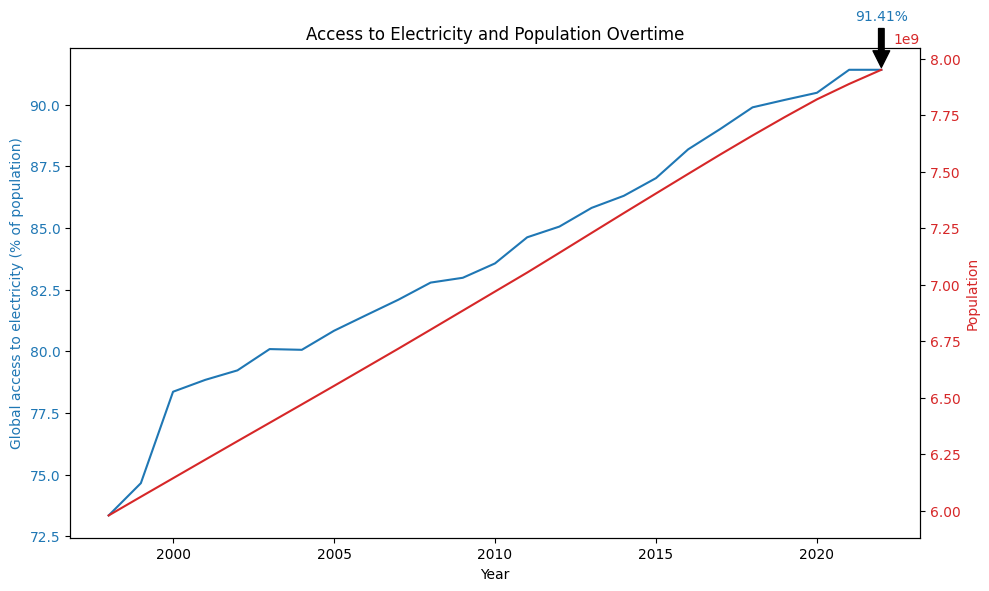

In [70]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the access to electricity data on the primary y-axis
ax1.plot(world_data['Year'], world_data['Access to electricity (% of population)'], label='Access to Electricity', color='tab:blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Global access to electricity (% of population)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Annotate the last data point for access to electricity
last_year = world_data['Year'].iloc[-1]
last_electricity_value = world_data['Access to electricity (% of population)'].iloc[-1]
ax1.annotate(f'{last_electricity_value:.2f}%', xy=(last_year, last_electricity_value), xytext=(last_year, last_electricity_value + 2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             ha='center', color='tab:blue')

# Create a secondary y-axis for the population data
ax2 = ax1.twinx()
ax2.plot(world_data['Year'], world_data['Population'], label='Population', color='tab:red')
ax2.set_ylabel('Population', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')


plt.title('Access to Electricity and Population Overtime')
fig.tight_layout() 
plt.show()

- Access to electricity by % of world population keeps increasing year on year

#### Acess to electricity by Region

In [71]:
regions = [
    'Africa Eastern and Southern', 'Africa Western and Central', 'Central Europe and the Baltics',
    'East Asia & Pacific', 'Europe & Central Asia', 'European Union', 'Latin America & Caribbean',
    'Middle East & North Africa', 'North America', 'South Asia', 'Sub-Saharan Africa'
]

# Filter the DataFrame for the specified regions
filtered_data = dataframe[dataframe['Country Name'].isin(regions)]

# Drop rows with missing values in 'Access to electricity (% of population)' and 'Year'
filtered_data = filtered_data.dropna(subset=['Access to electricity (% of population)', 'Year'])

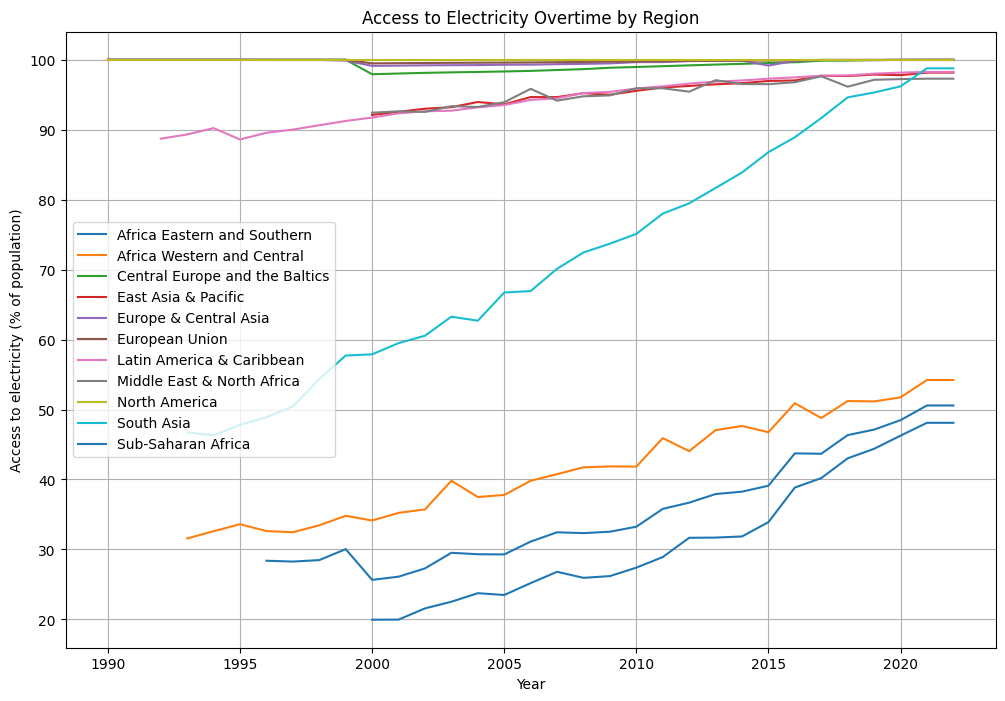

In [72]:
plt.figure(figsize=(12, 8))

# Iterate through each region and plot their data
for region in regions:
    region_data = filtered_data[filtered_data['Country Name'] == region].sort_values(by='Year')
    plt.plot(region_data['Year'], region_data['Access to electricity (% of population)'], label=region)


plt.xlabel('Year')
plt.ylabel('Access to electricity (% of population)')
plt.title('Access to Electricity Overtime by Region')
plt.legend()
plt.grid(True)
plt.show()

- Some regions have significantly more access than others

#### Access to electricity by income

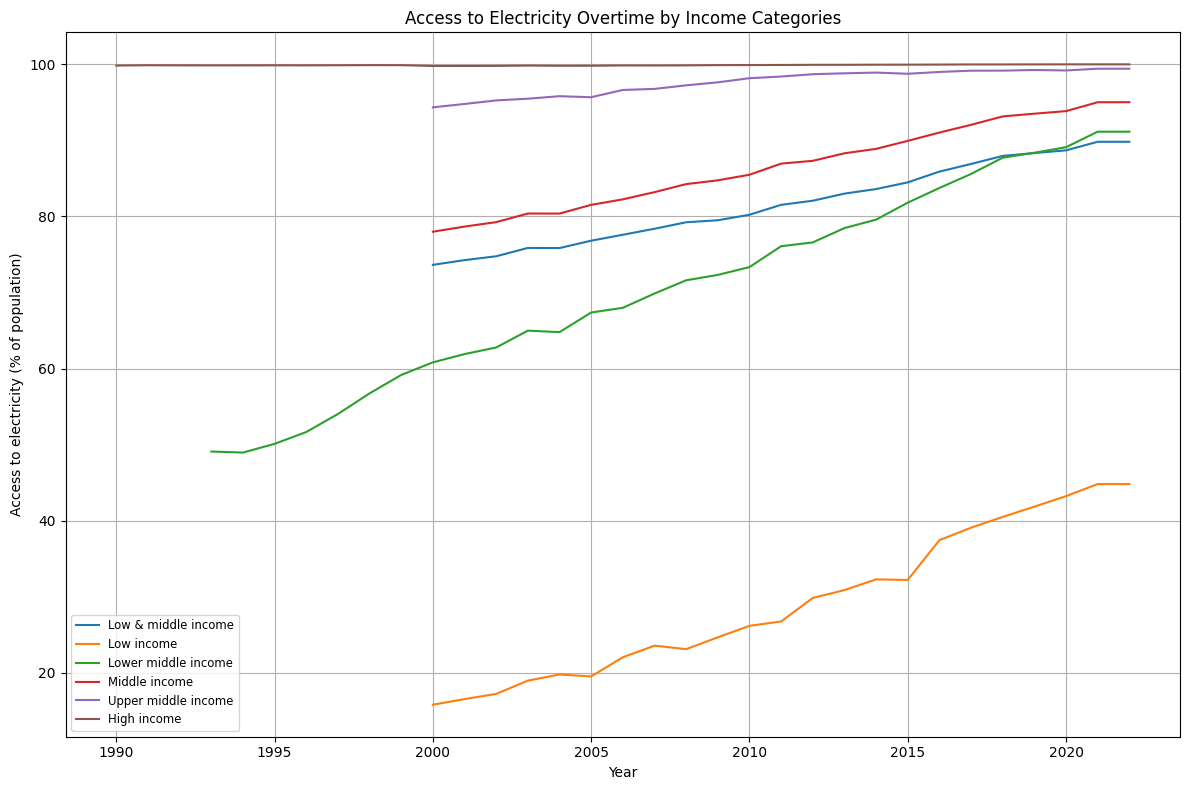

In [73]:
# List of specified income categories
income_categories = [
    'Low & middle income', 'Low income', 'Lower middle income',
    'Middle income', 'Upper middle income', 'High income'
]

filtered_data = dataframe[dataframe['Country Name'].isin(income_categories)]

# Drop rows with missing values in 'Access to electricity (% of population)' and 'Year'
filtered_data = filtered_data.dropna(subset=['Access to electricity (% of population)', 'Year'])

plt.figure(figsize=(12, 8))

# Iterate through each income category and plot their data with unique colors
for i, income_category in enumerate(income_categories):
    income_data = filtered_data[filtered_data['Country Name'] == income_category].sort_values(by='Year')
    plt.plot(income_data['Year'], income_data['Access to electricity (% of population)'], label=income_category)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Access to electricity (% of population)')
plt.title('Access to Electricity Overtime by Income Categories')
plt.legend(loc='best', fontsize='small')
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

- Income is a big factor in access to electricity

#### Access to electricity by demographic dividend

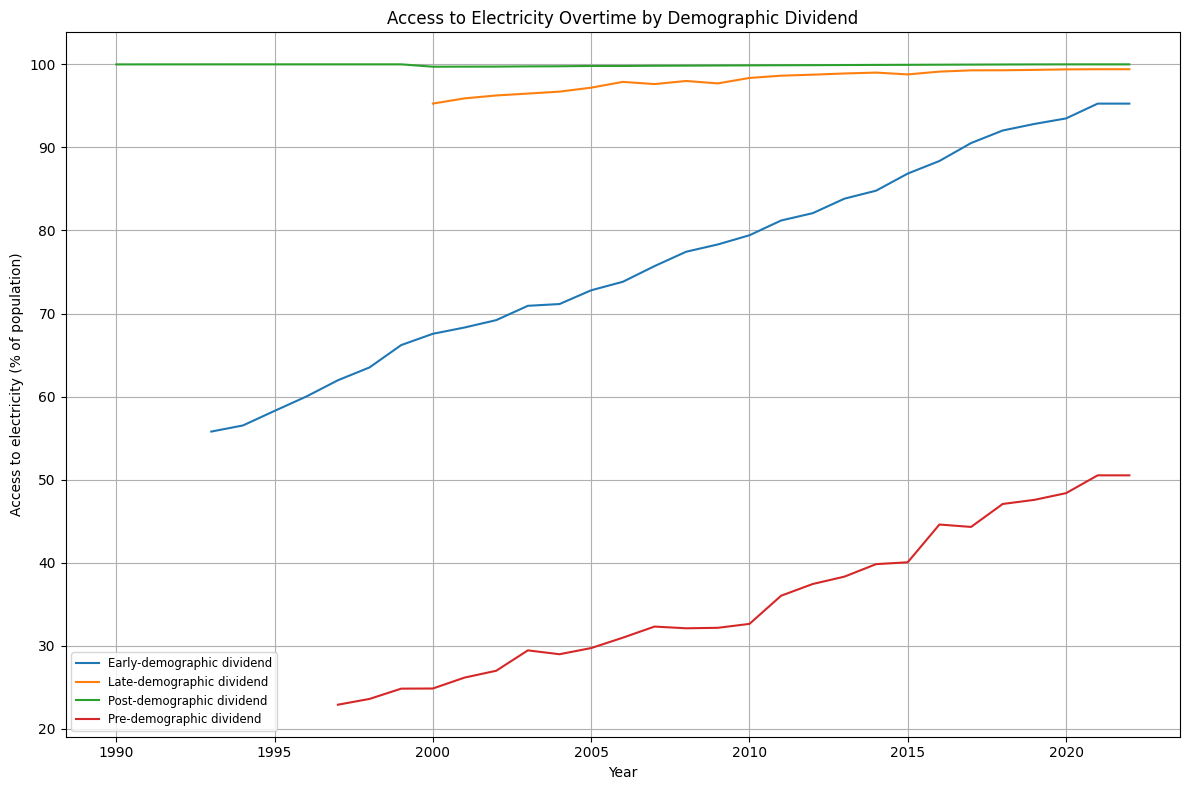

In [75]:
filtered_data = dataframe[dataframe['Country Name'].isin([
    'Post-demographic dividend', 'Pre-demographic dividend',
    'Late-demographic dividend', 'Early-demographic dividend'
])]

# Drop rows with missing values in 'Access to electricity (% of population)' and 'Year'
filtered_data = filtered_data.dropna(subset=['Access to electricity (% of population)', 'Year'])


plt.figure(figsize=(12, 8))

# Iterate through each demographic division and plot their data
for country in filtered_data['Country Name'].unique():
    country_data = filtered_data[filtered_data['Country Name'] == country].sort_values(by='Year')
    plt.plot(country_data['Year'], country_data['Access to electricity (% of population)'], label=country)


plt.xlabel('Year')
plt.ylabel('Access to electricity (% of population)')
plt.title('Access to Electricity Overtime by Demographic Dividend')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

- demographic dividend plays a huge role in access to electricity

#### Other Classifications

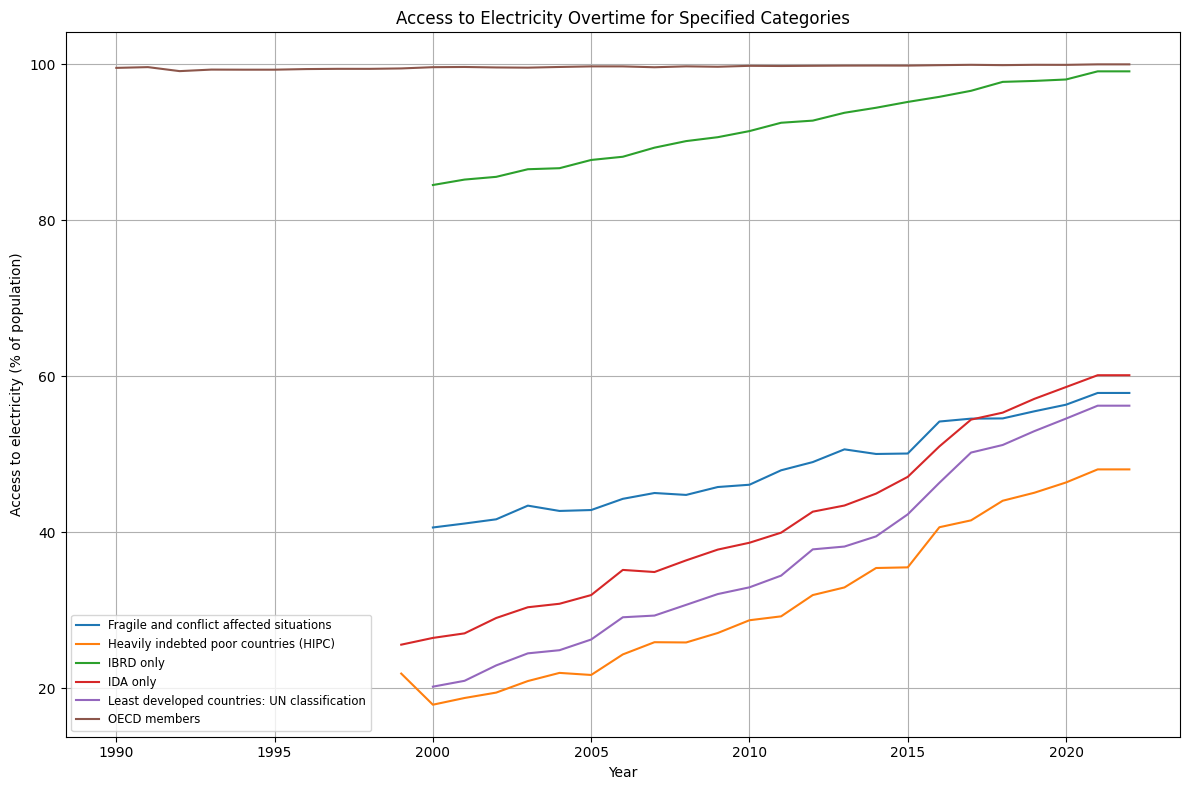

In [77]:
# Filter the DataFrame for the specified categories
filtered_data = dataframe[dataframe['Country Name'].isin([
    'Fragile and conflict affected situations',
    'Heavily indebted poor countries (HIPC)',
    'IBRD only',
    'IDA only',
    'Least developed countries: UN classification',
    'OECD members'
])]

# Drop rows with missing values in 'Access to electricity (% of population)' and 'Year'
filtered_data = filtered_data.dropna(subset=['Access to electricity (% of population)', 'Year'])


plt.figure(figsize=(12, 8))

# Iterate through each category and plot their data
for country in filtered_data['Country Name'].unique():
    country_data = filtered_data[filtered_data['Country Name'] == country].sort_values(by='Year')
    plt.plot(country_data['Year'], country_data['Access to electricity (% of population)'], label=country)


plt.xlabel('Year')
plt.ylabel('Access to electricity (% of population)')
plt.title('Access to Electricity Overtime for Specified Categories')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Correlation

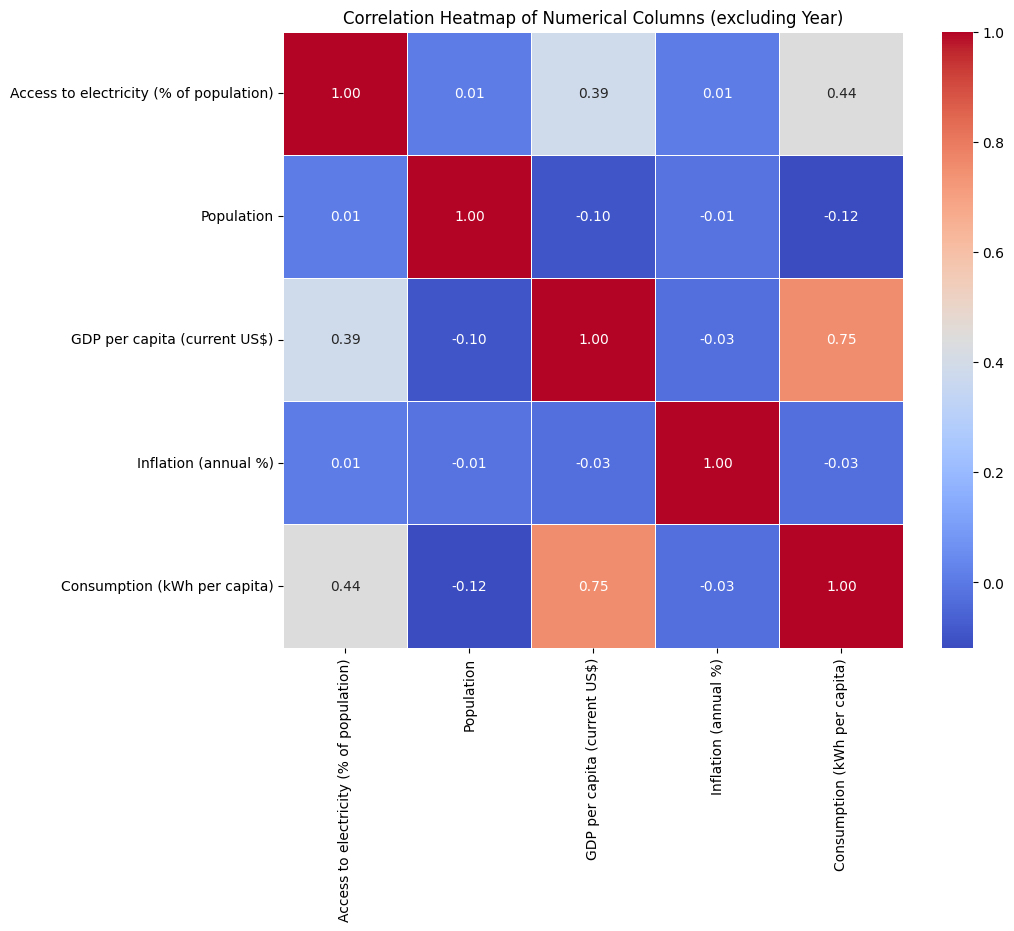

In [79]:
numerical_data = dataframe.drop(columns=['Year', 'Country Name','Country Code','Region','IncomeGroup', 'SpecialNotes','CountryNameMeta'])

correlation_matrix = numerical_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns (excluding Year)')
plt.show()

- GDP per capita and Access to electricity (% of population) are highly correlated to consumption (kWh per capita)

## Final Data Cleaning

In [80]:
df = elec_pop_gdp_cpi_consumption_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
 9   GDP per capita (current US$)             8225 non-null   float64 
 10  Inflation (annual %)                

In [82]:
# Check unique Country Name/Regions in Country Name & TableName
# Convert the columns to sets for comparison
set1 = set(df['Country Name'])
set2 = set(df['CountryNameMeta'])

# Find elements in set1 not in set2
only_in_set1 = list(set1 - set2)

# Find elements in set2 not in set1
only_in_set2 = list(set2 - set1)

# Create a new DataFrame to hold the results
comparison_df = pd.DataFrame({
    'Only in Country Name': pd.Series(only_in_set1),
    'Only in CountryNameMeta': pd.Series(only_in_set2)
})

# Display the resulting DataFrame
comparison_df

,Only in Country Name,Only in CountryNameMeta
0,Sub-Saharan Africa (IDA & IBRD countries),Europe & Central Asia (IDA & IBRD)
1,Latin America & the Caribbean (IDA & IBRD coun...,São Tomé and Principe
2,Sao Tome and Principe,Türkiye
3,Europe & Central Asia (IDA & IBRD countries),East Asia & Pacific (IDA & IBRD)
4,Middle East & North Africa (IDA & IBRD countries),Côte d'Ivoire
5,East Asia & Pacific (IDA & IBRD countries),Sub-Saharan Africa (IDA & IBRD)
6,Turkiye,Latin America & Caribbean (IDA & IBRD)
7,Curacao,Curaçao
8,Cote d'Ivoire,Middle East & North Africa (IDA & IBRD)


In [83]:
# Rename countries/regions in metadata dataset before merging

rename_dict = {
    "Côte d'Ivoire": "Cote d'Ivoire",
    'East Asia & Pacific (IDA & IBRD)': 'East Asia & Pacific (IDA & IBRD countries)',
    'Sub-Saharan Africa (IDA & IBRD)': 'Sub-Saharan Africa (IDA & IBRD countries)',
    'Latin America & Caribbean (IDA & IBRD)': 'Latin America & the Caribbean (IDA & IBRD countries)',
    'Europe & Central Asia (IDA & IBRD)': 'Europe & Central Asia (IDA & IBRD countries)',
    'Türkiye': 'Turkiye',
    'Middle East & North Africa (IDA & IBRD)': 'Middle East & North Africa (IDA & IBRD countries)',
    'São Tomé and Principe': 'Sao Tome and Principe',
    'Curaçao': 'Curacao'
}

df['CountryNameMeta'] = df['CountryNameMeta'].replace(rename_dict)

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8745 non-null   int64   
 1   Country Name                             8745 non-null   category
 2   Country Code                             8745 non-null   object  
 3   Access to electricity (% of population)  7611 non-null   float64 
 4   Region                                   7161 non-null   object  
 5   IncomeGroup                              7128 non-null   object  
 6   SpecialNotes                             4158 non-null   object  
 7   CountryNameMeta                          8745 non-null   object  
 8   Population                               8745 non-null   float64 
 9   GDP per capita (current US$)             8225 non-null   float64 
 10  Inflation (annual %)                

In [85]:
# drop unwanted column
df.drop(columns = ["Country Name", "Region", "IncomeGroup", "Country Code", "SpecialNotes"], inplace = True)
df.head()

,Year,Access to electricity (% of population),CountryNameMeta,Population,GDP per capita (current US$),Inflation (annual %),Consumption (kWh per capita)
0,1990,NaN,Afghanistan,10694796.0,NaN,NaN,NaN
1,1991,NaN,Afghanistan,10745167.0,NaN,NaN,NaN
2,1992,NaN,Afghanistan,12057433.0,NaN,NaN,NaN
3,1993,NaN,Afghanistan,14003760.0,NaN,NaN,NaN
4,1994,NaN,Afghanistan,15455555.0,NaN,NaN,NaN


In [87]:
df['CountryNameMeta'].value_counts()

CountryNameMeta
Afghanistan                                             33
Norway                                                  33
Mozambique                                              33
Myanmar                                                 33
Namibia                                                 33
Nauru                                                   33
Nepal                                                   33
Netherlands                                             33
New Caledonia                                           33
New Zealand                                             33
Nicaragua                                               33
Niger                                                   33
Nigeria                                                 33
North America                                           33
North Macedonia                                         33
Northern Mariana Islands                                33
OECD members                            

In [88]:
df.rename(columns={'CountryNameMeta': 'Country/Region'}, inplace=True)

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Year                                     8745 non-null   int64  
 1   Access to electricity (% of population)  7611 non-null   float64
 2   Country/Region                           8745 non-null   object 
 3   Population                               8745 non-null   float64
 4   GDP per capita (current US$)             8225 non-null   float64
 5   Inflation (annual %)                     7173 non-null   float64
 6   Consumption (kWh per capita)             4560 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 478.4+ KB


In [90]:
#reorganize the dataframe
df = df[
    ["Year", "Country/Region", "Population","GDP per capita (current US$)",
     "Inflation (annual %)", "Access to electricity (% of population)",
     "Consumption (kWh per capita)"
     ]
    ]

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8745 entries, 0 to 8744
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Year                                     8745 non-null   int64  
 1   Country/Region                           8745 non-null   object 
 2   Population                               8745 non-null   float64
 3   GDP per capita (current US$)             8225 non-null   float64
 4   Inflation (annual %)                     7173 non-null   float64
 5   Access to electricity (% of population)  7611 non-null   float64
 6   Consumption (kWh per capita)             4560 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 478.4+ KB


In [92]:
df['Country/Region'] = df['Country/Region'].astype('category')

In [93]:
# Drop rows where all specified columns are null
df = df.dropna(subset=[
    'GDP per capita (current US$)', 
    'Inflation (annual %)', 
    'Access to electricity (% of population)', 
    'Consumption (kWh per capita)'
], how='all')

In [94]:
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8661 entries, 0 to 8660
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Year                                     8661 non-null   int64   
 1   Country/Region                           8661 non-null   category
 2   Population                               8661 non-null   float64 
 3   GDP per capita (current US$)             8225 non-null   float64 
 4   Inflation (annual %)                     7173 non-null   float64 
 5   Access to electricity (% of population)  7611 non-null   float64 
 6   Consumption (kWh per capita)             4560 non-null   float64 
dtypes: category(1), float64(5), int64(1)
memory usage: 433.2 KB


In [95]:
# Fill the remaining null values with MICE imputation

mice_kernel = ImputationKernel(data = df, save_all_iterations = True, random_state = 42)
mice_kernel.mice(10)
imputed_df = mice_kernel.complete_data()
imputed_df.head()

c:\Users\jmutonyi\Desktop\Data Science\Hamoye Data Science Internship\Premier Project\Predicting Future Electrification Needs\venv\Lib\site-packages\miceforest\ImputationKernel.py:370: UserWarning: [Country/Region] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


,Year,Country/Region,Population,GDP per capita (current US$),Inflation (annual %),Access to electricity (% of population),Consumption (kWh per capita)
0,2000,Afghanistan,19542982.0,242.575727,7.141965,4.446891,70.173035
1,2001,Afghanistan,19688632.0,625.203249,8.176361,9.294527,96.471364
2,2002,Afghanistan,21000256.0,182.174037,3.652026,14.133616,77.209679
3,2003,Afghanistan,22645130.0,199.643228,7.694264,18.971165,298.434469
4,2004,Afghanistan,23553551.0,221.830531,9.758880,23.814182,68.866500


In [96]:
imputed_df['Year'] = pd.to_datetime(imputed_df['Year'], format='%Y')

In [97]:
imputed_df = imputed_df.set_index('Year')

In [98]:
imputed_df["Year_Col"] = imputed_df.index.year

In [99]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8661 entries, 2000-01-01 to 2022-01-01
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Country/Region                           8661 non-null   category
 1   Population                               8661 non-null   float64 
 2   GDP per capita (current US$)             8661 non-null   float64 
 3   Inflation (annual %)                     8661 non-null   float64 
 4   Access to electricity (% of population)  8661 non-null   float64 
 5   Consumption (kWh per capita)             8661 non-null   float64 
 6   Year_Col                                 8661 non-null   int32   
dtypes: category(1), float64(5), int32(1)
memory usage: 466.9 KB


In [100]:
df.describe()

,Year,Population,GDP per capita (current US$),Inflation (annual %),Access to electricity (% of population),Consumption (kWh per capita)
count,8661.000000,8.661000e+03,8225.000000,7173.000000,7611.000000,4560.000000
mean,2006.107493,2.701812e+08,12186.653513,20.902955,80.966314,3414.357739
std,9.498018,8.521746e+08,20438.750545,324.414973,28.582446,4620.968059
min,1990.000000,9.182000e+03,22.850371,-16.859691,0.533899,13.187383
25%,1998.000000,1.379350e+06,1159.340201,2.077151,68.879587,582.311790
50%,2006.000000,9.051539e+06,3796.109600,4.134709,98.401421,1778.749088
75%,2014.000000,5.801903e+07,14632.690308,8.031667,100.000000,4626.893896
max,2022.000000,7.950947e+09,240862.182448,23773.131774,100.000000,54799.174708


In [101]:
imputed_df.describe()

,Population,GDP per capita (current US$),Inflation (annual %),Access to electricity (% of population),Consumption (kWh per capita),Year_Col
count,8.661000e+03,8661.000000,8661.000000,8661.000000,8661.000000,8661.000000
mean,2.701812e+08,12366.230517,25.729147,78.682196,3375.982651,2006.107493
std,8.521746e+08,20489.547103,318.156794,29.566670,4158.857287,9.498018
min,9.182000e+03,22.850371,-16.859691,0.533899,13.187383,1990.000000
25%,1.379350e+06,1204.862055,1.992015,62.109650,633.390640,1998.000000
50%,9.051539e+06,3971.803488,4.037030,96.646523,2058.231008,2006.000000
75%,5.801903e+07,14987.307257,8.105833,100.000000,5028.524445,2014.000000
max,7.950947e+09,240862.182448,23773.131774,100.000000,54799.174708,2022.000000


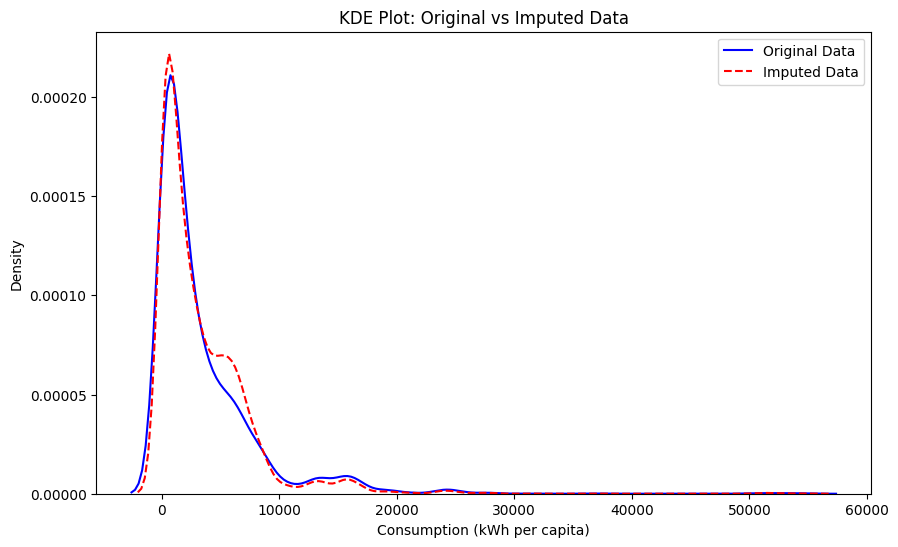

In [102]:
# Plot KDE for original and imputed data
plt.figure(figsize=(10, 6))

# KDE for original data (excluding NaNs)
sns.kdeplot(df['Consumption (kWh per capita)'].dropna(), label='Original Data', color='blue')

# KDE for imputed data
sns.kdeplot(imputed_df['Consumption (kWh per capita)'], label='Imputed Data', color='red', linestyle='--')

plt.title('KDE Plot: Original vs Imputed Data')
plt.xlabel('Consumption (kWh per capita)')
plt.ylabel('Density')
plt.legend()
plt.show()

## Train-Test Split

In [98]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8661 entries, 2000-01-01 to 2022-01-01
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   Country/Region                           8661 non-null   category
 1   Population                               8661 non-null   float64 
 2   GDP per capita (current US$)             8661 non-null   float64 
 3   Inflation (annual %)                     8661 non-null   float64 
 4   Access to electricity (% of population)  8661 non-null   float64 
 5   Consumption (kWh per capita)             8661 non-null   float64 
 6   Year_Col                                 8661 non-null   int32   
dtypes: category(1), float64(5), int32(1)
memory usage: 466.9 KB


In [99]:
split_date = '2015-01-01'

# Create train and test splits based on the index order
training_set = imputed_df.loc[imputed_df.index < split_date]
eval_set = imputed_df.loc[imputed_df.index >= split_date]

training_set.shape, eval_set.shape

((6541, 7), (2120, 7))

In [100]:
# Training data
X_train = training_set.drop(columns = ["Consumption (kWh per capita)"])
y_train = training_set["Consumption (kWh per capita)"]

#Evaluation  set
X_test = eval_set.drop(columns = ["Consumption (kWh per capita)"])
y_test = eval_set["Consumption (kWh per capita)"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6541, 6), (6541,), (2120, 6), (2120,))

## Encoding & Scaling

In [101]:
categorical = ['Country/Region']

numerical = ['Population', 'GDP per capita (current US$)', 'Inflation (annual %)', 'Access to electricity (% of population)', 'Year_Col']

In [102]:
# scale numerical values using StandardScaler
# convert the output back to a dataframe and put back the column names

scaler = StandardScaler()

Scaled_Train = scaler.fit_transform(X_train[numerical])
Scaled_Test = scaler.transform(X_test[numerical])

# Create new DataFrames with the scaled values
Scaled_Train_df = pd.DataFrame(Scaled_Train, columns=numerical)
Scaled_Test_df = pd.DataFrame(Scaled_Test, columns=numerical)

In [103]:
Scaled_Train_df.head()

,Population,GDP per capita (current US$),Inflation (annual %),Access to electricity (% of population),Year_Col
0,-0.293177,-0.583128,-0.068506,-2.340774,-0.290445
1,-0.292997,-0.562077,-0.065677,-2.183398,-0.151540
2,-0.291372,-0.586451,-0.078050,-2.026299,-0.012635
3,-0.289333,-0.585490,-0.066995,-1.869250,0.126269
4,-0.288208,-0.584269,-0.061349,-1.712023,0.265174


In [104]:
transformer = make_column_transformer(
    (OneHotEncoder(sparse_output=False), categorical)
)

Encoded_Train = transformer.fit_transform(X_train[categorical])
Encoded_Test = transformer.transform(X_test[categorical])

# Transforming back to a dataframe
Encoded_Train_df = pd.DataFrame(Encoded_Train, columns=transformer.get_feature_names_out())
Encoded_Test_df = pd.DataFrame(Encoded_Test, columns=transformer.get_feature_names_out())

In [105]:
Encoded_Train_df.columns = Encoded_Train_df.columns.str.replace('onehotencoder__', '')
Encoded_Test_df.columns = Encoded_Test_df.columns.str.replace('onehotencoder__', '')

In [106]:
train_df = pd.concat([Scaled_Train_df, Encoded_Train_df], axis=1)
test_df = pd.concat([Scaled_Test_df, Encoded_Test_df], axis=1)

In [107]:
train_df.shape, y_train.shape

((6541, 270), (6541,))

In [108]:
train_df.head()

,Population,GDP per capita (current US$),Inflation (annual %),Access to electricity (% of population),Year_Col,Country/Region_Afghanistan,Country/Region_Africa Eastern and Southern,Country/Region_Africa Western and Central,Country/Region_Albania,Country/Region_Algeria,Country/Region_American Samoa,Country/Region_Andorra,Country/Region_Angola,Country/Region_Antigua and Barbuda,Country/Region_Arab World,Country/Region_Argentina,Country/Region_Armenia,Country/Region_Aruba,Country/Region_Australia,Country/Region_Austria,Country/Region_Azerbaijan,"Country/Region_Bahamas, The",Country/Region_Bahrain,Country/Region_Bangladesh,Country/Region_Barbados,Country/Region_Belarus,Country/Region_Belgium,Country/Region_Belize,Country/Region_Benin,Country/Region_Bermuda,Country/Region_Bhutan,Country/Region_Bolivia,Country/Region_Bosnia and Herzegovina,Country/Region_Botswana,Country/Region_Brazil,Country/Region_British Virgin Islands,Country/Region_Brunei Darussalam,Country/Region_Bulgaria,Country/Region_Burkina Faso,Country/Region_Burundi,Country/Region_Cabo Verde,Country/Region_Cambodia,Country/Region_Cameroon,Country/Region_Canada,Country/Region_Caribbean small states,Country/Region_Cayman Islands,Country/Region_Central African Republic,Country/Region_Central Europe and the Baltics,Country/Region_Chad,Country/Region_Channel Islands,Country/Region_Chile,Country/Region_China,Country/Region_Colombia,Country/Region_Comoros,"Country/Region_Congo, Dem. Rep.","Country/Region_Congo, Rep.",Country/Region_Costa Rica,Country/Region_Cote d'Ivoire,Country/Region_Croatia,Country/Region_Cuba,Country/Region_Curacao,Country/Region_Cyprus,Country/Region_Czechia,Country/Region_Denmark,Country/Region_Djibouti,Country/Region_Dominica,Country/Region_Dominican Republic,Country/Region_Early-demographic dividend,Country/Region_East Asia & Pacific,Country/Region_East Asia & Pacific (IDA & IBRD countries),Country/Region_East Asia & Pacific (excluding high income),Country/Region_Ecuador,"Country/Region_Egypt, Arab Rep.",Country/Region_El Salvador,Country/Region_Equatorial Guinea,Country/Region_Eritrea,Country/Region_Estonia,Country/Region_Eswatini,Country/Region_Ethiopia,Country/Region_Euro area,Country/Region_Europe & Central Asia,Country/Region_Europe & Central Asia (IDA & IBRD countries),Country/Region_Europe & Central Asia (excluding high income),Country/Region_European Union,Country/Region_Faroe Islands,Country/Region_Fiji,Country/Region_Finland,Country/Region_Fragile and conflict affected situations,Country/Region_France,Country/Region_French Polynesia,Country/Region_Gabon,"Country/Region_Gambia, The",Country/Region_Georgia,Country/Region_Germany,Country/Region_Ghana,Country/Region_Gibraltar,Country/Region_Greece,Country/Region_Greenland,Country/Region_Grenada,Country/Region_Guam,Country/Region_Guatemala,Country/Region_Guinea,Country/Region_Guinea-Bissau,Country/Region_Guyana,Country/Region_Haiti,Country/Region_Heavily indebted poor countries (HIPC),Country/Region_High income,Country/Region_Honduras,"Country/Region_Hong Kong SAR, China",Country/Region_Hungary,Country/Region_IBRD only,Country/Region_IDA & IBRD total,Country/Region_IDA blend,Country/Region_IDA only,Country/Region_IDA total,Country/Region_Iceland,Country/Region_India,Country/Region_Indonesia,"Country/Region_Iran, Islamic Rep.",Country/Region_Iraq,Country/Region_Ireland,Country/Region_Isle of Man,Country/Region_Israel,Country/Region_Italy,Country/Region_Jamaica,Country/Region_Japan,Country/Region_Jordan,Country/Region_Kazakhstan,Country/Region_Kenya,Country/Region_Kiribati,"Country/Region_Korea, Dem. People's Rep.","Country/Region_Korea, Rep.",Country/Region_Kosovo,Country/Region_Kuwait,Country/Region_Kyrgyz Republic,Country/Region_Lao PDR,Country/Region_Late-demographic dividend,Country/Region_Latin America & Caribbean,Country/Region_Latin America & Caribbean (excluding high income),Country/Region_Latin America & the Caribbean (IDA & IBRD countries),Country/Region_Latvia,Country/Region_Least develop

In [109]:
test_df.shape, y_test.shape

((2120, 270), (2120,))

In [110]:
# Extract the original index column for later use
y_train_index = y_train.index
y_test_index = y_test.index

In [111]:
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)

## Modeling

In [112]:
mean_baseline = y_train.mean()
median_baseline = y_train.median()

# Calculate RMSE for the baseline models
rmse_mean_baseline = np.sqrt(mean_squared_error(y_train, [mean_baseline] * len(y_train)))
rmse_median_baseline = np.sqrt(mean_squared_error(y_train, [median_baseline] * len(y_train)))

print(f'RMSE for Mean Baseline: {rmse_mean_baseline}')
print(f'RMSE for Median Baseline: {rmse_median_baseline}')

RMSE for Mean Baseline: 4116.557095319252
RMSE for Median Baseline: 4354.278209977742


### Linear Regression

In [113]:
LR = LinearRegression()

LR.fit(train_df, y_train)
LR_pred = LR.predict(test_df)

In [114]:
df = pd.DataFrame({
    'Actual Consumption (kWh per capita)': y_test,
    'Predicted Consumption (kWh per capita)': LR_pred
})
df.index = y_test_index
df.head(10)

,Actual Consumption (kWh per capita),Predicted Consumption (kWh per capita)
Year,,
2015-01-01,334.171312,686.2500
2016-01-01,1231.006551,808.6250
2017-01-01,808.418972,846.4375
2018-01-01,1097.265385,868.8750
2019-01-01,855.948165,920.7500
2020-01-01,956.000000,958.9375
2021-01-01,872.849309,992.6875
2022-01-01,3413.370550,1227.9375
2015-01-01,691.958090,1237.1875


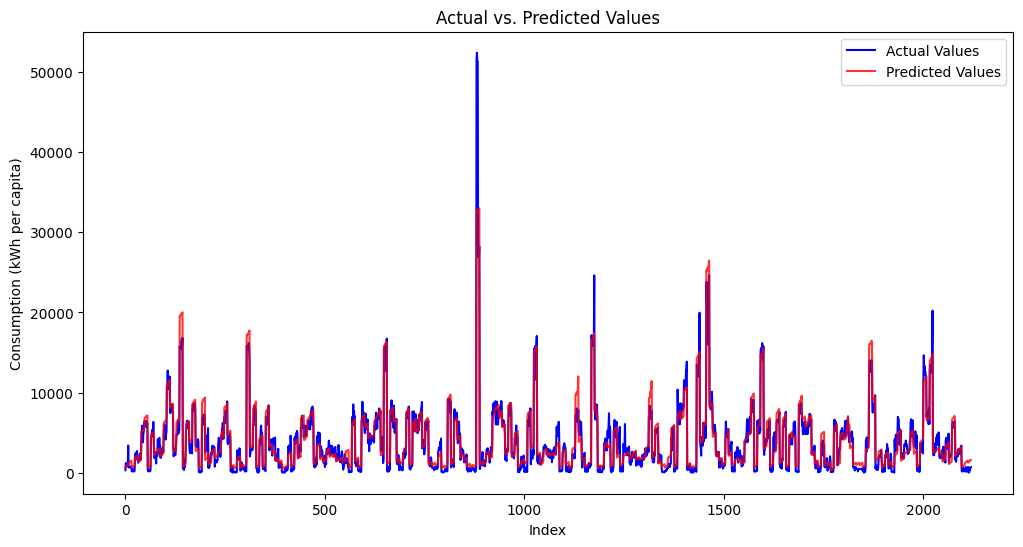

In [115]:
# plot the actual vs. predicted values

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(LR_pred, color='red', label='Predicted Values', alpha = 0.8)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Consumption (kWh per capita)")
plt.title("Actual vs. Predicted Values")

# Add legend
plt.legend()

# Show plot
plt.show()

### Random Forest Regressor

In [122]:
RF = RandomForestRegressor(random_state=42)

RF.fit(train_df, y_train)
RF_pred = RF.predict(test_df)

In [123]:
df = pd.DataFrame({
    'Actual Consumption (kWh per capita)': y_test,
    'Predicted Consumption (kWh per capita)': RF_pred
})
df.index = y_test_index
df.head(10)

,Actual Consumption (kWh per capita),Predicted Consumption (kWh per capita)
Year,,
2015-01-01,334.171312,681.115330
2016-01-01,1231.006551,1249.338309
2017-01-01,808.418972,1252.298904
2018-01-01,1097.265385,1041.189136
2019-01-01,855.948165,1257.832608
2020-01-01,956.000000,1255.566924
2021-01-01,872.849309,1270.700434
2022-01-01,3413.370550,1929.398133
2015-01-01,691.958090,694.848584


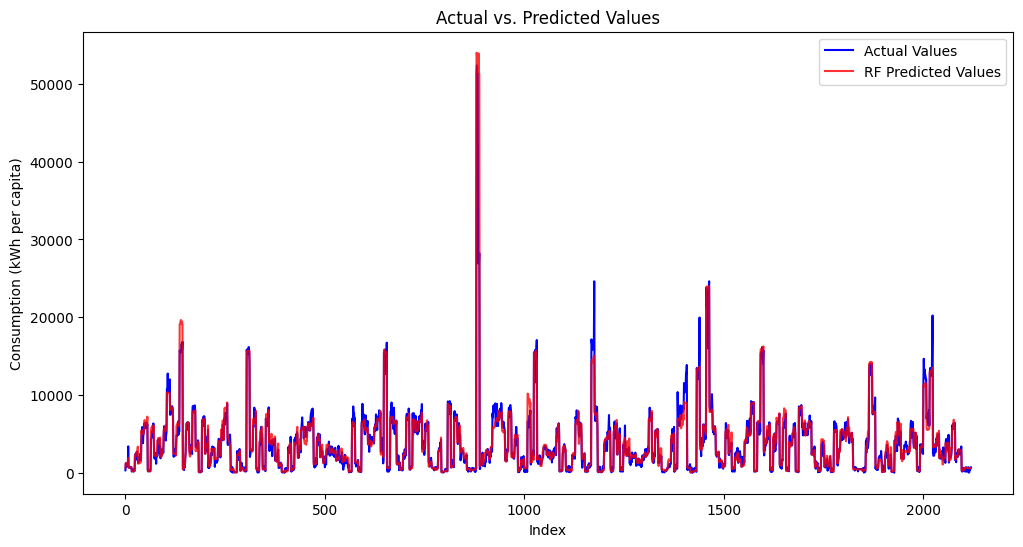

In [124]:
# plot the actual vs. predicted values

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(RF_pred, color='red', label='RF Predicted Values', alpha = 0.8)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Consumption (kWh per capita)")
plt.title("Actual vs. Predicted Values")

# Add legend
plt.legend()

# Show plot
plt.show()

### Gradient Boosting Regressor

In [125]:
GB = GradientBoostingRegressor(random_state=42)

GB.fit(train_df, y_train)
GB_pred = GB.predict(test_df)

In [126]:
df = pd.DataFrame({
    'Actual Consumption (kWh per capita)': y_test,
    'Predicted Consumption (kWh per capita)': GB_pred
})
df.index = y_test_index
df.tail(10)

,Actual Consumption (kWh per capita),Predicted Consumption (kWh per capita)
Year,,
2021-01-01,167.154086,331.154050
2022-01-01,582.580474,390.505354
2015-01-01,721.107944,390.505354
2016-01-01,721.107944,390.505354
2017-01-01,31.745037,331.154050
2018-01-01,92.848912,465.348418
2019-01-01,548.953753,390.505354
2020-01-01,407.036411,390.505354
2021-01-01,701.940863,422.189969


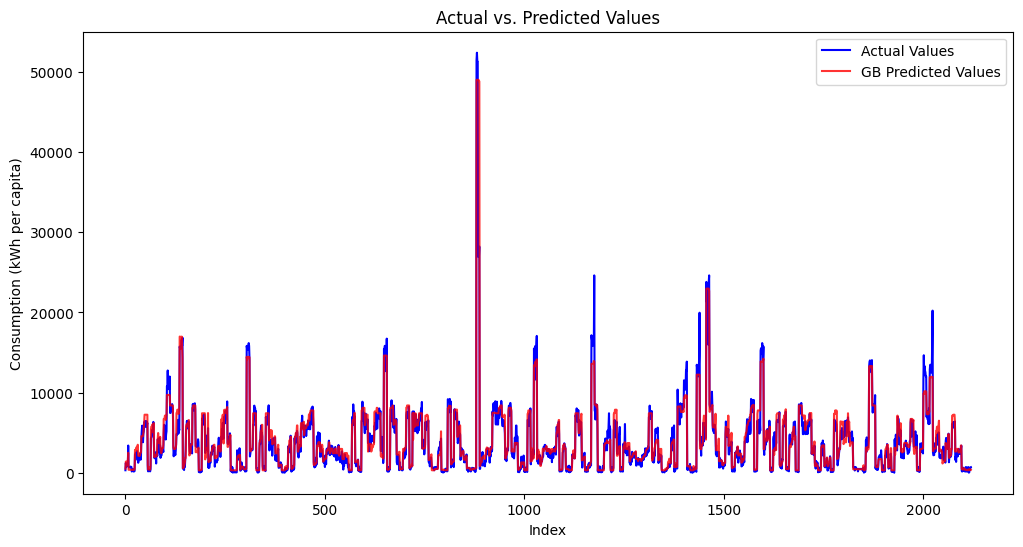

In [127]:
# plot the actual vs. predicted values

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(GB_pred, color='red', label='GB Predicted Values', alpha = 0.8)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Consumption (kWh per capita)")
plt.title("Actual vs. Predicted Values")

# Add legend
plt.legend()

# Show plot
plt.show()

### Decision Tree Regressor

In [128]:
DT = DecisionTreeRegressor(random_state=42)

DT.fit(train_df, y_train)
DT_pred = DT.predict(test_df)

In [129]:
df = pd.DataFrame({
    'Actual Consumption (kWh per capita)': y_test,
    'Predicted Consumption (kWh per capita)': DT_pred
})
df.index = y_test_index
df.head(10)

,Actual Consumption (kWh per capita),Predicted Consumption (kWh per capita)
Year,,
2015-01-01,334.171312,881.110330
2016-01-01,1231.006551,932.345064
2017-01-01,808.418972,932.345064
2018-01-01,1097.265385,1492.360429
2019-01-01,855.948165,932.345064
2020-01-01,956.000000,932.345064
2021-01-01,872.849309,932.345064
2022-01-01,3413.370550,1148.560242
2015-01-01,691.958090,680.149943


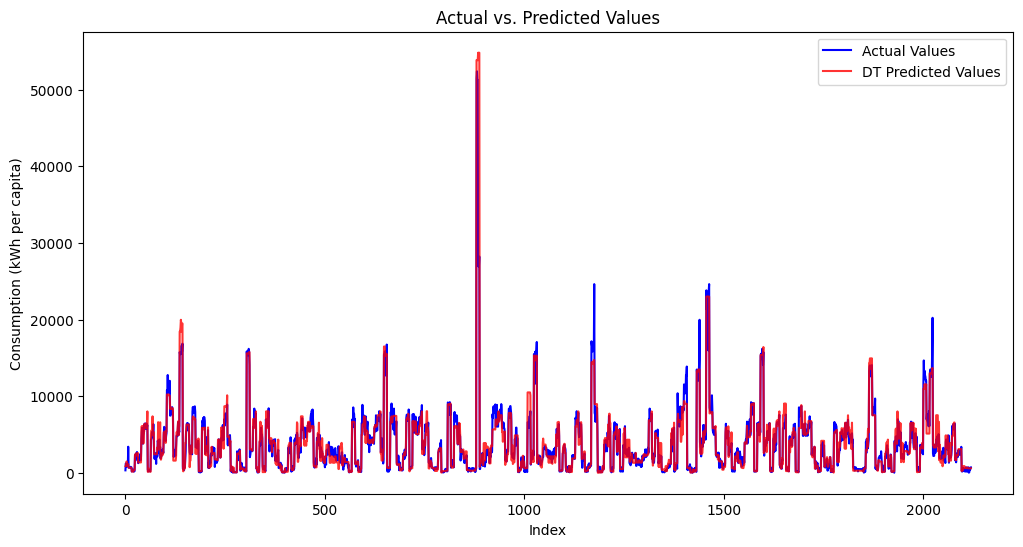

In [130]:
# plot the actual vs. predicted values

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(DT_pred, color='red', label='DT Predicted Values', alpha = 0.8)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Consumption (kWh per capita)")
plt.title("Actual vs. Predicted Values")

# Add legend
plt.legend()

# Show plot
plt.show()

### KNeighbors Regressor

In [133]:
KN = KNeighborsRegressor()

KN.fit(train_df, y_train)
KN_pred = KN.predict(test_df)

In [134]:
df = pd.DataFrame({
    'Actual Consumption (kWh per capita)': y_test,
    'Predicted Consumption (kWh per capita)': KN_pred
})
df.index = y_test_index
df.head(10)

,Actual Consumption (kWh per capita),Predicted Consumption (kWh per capita)
Year,,
2015-01-01,334.171312,621.671453
2016-01-01,1231.006551,1203.735337
2017-01-01,808.418972,1203.735337
2018-01-01,1097.265385,1189.192814
2019-01-01,855.948165,1203.735337
2020-01-01,956.000000,1203.735337
2021-01-01,872.849309,1203.735337
2022-01-01,3413.370550,1071.844229
2015-01-01,691.958090,707.778920


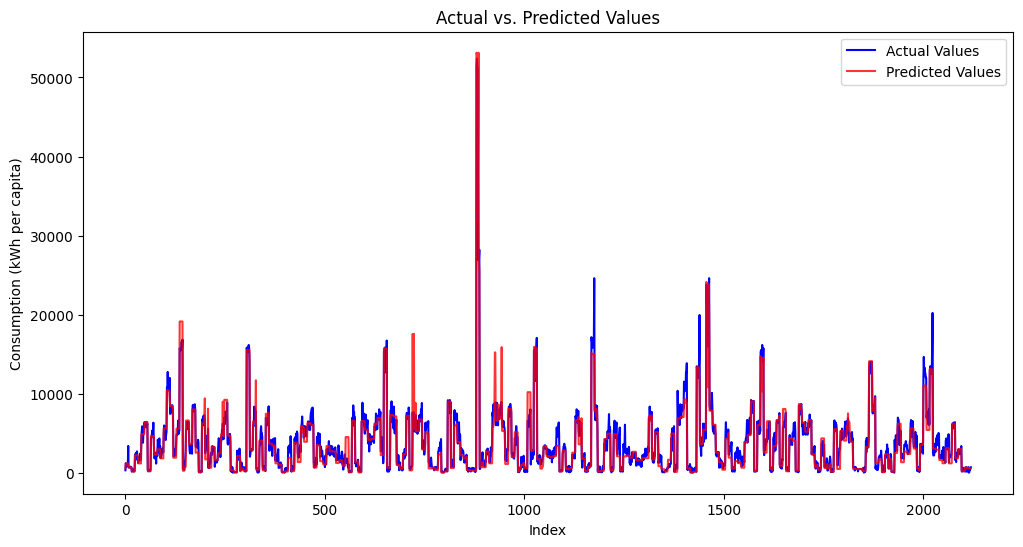

In [135]:
# plot the actual vs. predicted values

plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Actual Values')

# Plot predicted values
plt.plot(KN_pred, color='red', label='Predicted Values', alpha = 0.8)

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Consumption (kWh per capita)")
plt.title("Actual vs. Predicted Values")

# Add legend
plt.legend()

# Show plot
plt.show()

## Evaluation

#### Cross Validation

In [143]:
def k_fold_cross_validate_models(models, X, y, n_splits=5):
    """
    Perform k-fold cross-validation for each model.

    Parameters:
    models (dict): Dictionary containing trained models.
    X (DataFrame): Features.
    y (Series): Target variable.
    n_splits (int): Number of splits (folds) for cross-validation. Default is 5.

    Returns:
    DataFrame: DataFrame containing mean RMSE and standard deviation for each model.
    """
    results = []

    # Create KFold splitter
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for name, model in models.items():
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
        mean_rmse = -scores.mean()  # Convert negative RMSE back to positive
        std_rmse = scores.std()

        results.append([name, mean_rmse, std_rmse])

    # Create DataFrame
    results_df = pd.DataFrame(results, columns=['Model', 'Mean RMSE', 'Std RMSE'])

    return results_df

models = {
    'Linear Regression': LR,
    'Random Forest': RF,
    'Gradient Boosting': GB,
    'Decision Tree': DT,
    'KNeighbors': KN
}

# Perform k-fold cross-validation
cv_results_df = k_fold_cross_validate_models(models, train_df, y_train, n_splits=5)

# Display results DataFrame
cv_results_df.sort_values(by='Mean RMSE', ascending=True)

,Model,Mean RMSE,Std RMSE
1,Random Forest,458.668083,40.718913
4,KNeighbors,552.522769,100.134625
3,Decision Tree,679.772943,110.202227
2,Gradient Boosting,857.663369,42.736047
0,Linear Regression,1043.368513,193.595709


In [140]:
def calculate_metrics(models, X_eval, y_eval):
    """
    Calculate MSE, RMSE, RMSLE, and MSLE for each model.

    Parameters:
    models (dict): Dictionary containing trained models.
    X_eval (DataFrame): Evaluation features.
    y_eval (Series): Evaluation target variable.

    Returns:
    DataFrame: DataFrame containing metrics for each model.
    """
    metrics = []

    for name, model in models.items():
        # Predict target values
        y_pred = model.predict(X_eval)
        
        # Calculate metrics
        mse = mean_squared_error(y_eval, y_pred)
        rmse = np.sqrt(mse)
        msle = mean_squared_log_error(y_eval, y_pred)
        rmsle = np.sqrt(msle)
        r_squared = model.score(X_eval, y_eval)

        metrics.append([name, mse, rmse, msle, rmsle, r_squared])

    # Create DataFrame
    metrics_df = pd.DataFrame(metrics, columns=['Model', 'MSE', 'RMSE', 'MSLE', 'RMSLE', 'R^2'])

    return metrics_df

# Calculate metrics
metrics_df = calculate_metrics(models, test_df, y_test)

# Display metrics DataFrame
metrics_df

,Model,MSE,RMSE,MSLE,RMSLE,R^2
0,Linear Regression,1.788175e+06,1337.226446,0.456000,0.675277,0.901028
1,Random Forest,1.861505e+06,1364.369931,0.149502,0.386655,0.896970
2,Gradient Boosting,1.791768e+06,1338.569371,0.193919,0.440363,0.900830
3,Decision Tree,2.468669e+06,1571.199882,0.259381,0.509294,0.863365
4,KNeighbors,2.099059e+06,1448.813091,0.251561,0.501559,0.883822


## Hyperparameter Tuning

In [146]:
RF.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [148]:
# Random Forest tuning

# Define the parameter distributions for hyperparameter tuning
param_grid = {
  'n_estimators': [20, 50, 100, 200, 300],
  'max_depth': [None, 10, 15, 20, 25],
  'min_samples_split': [2, 3, 4, 5, 6],
  'min_samples_leaf': [1, 2, 3, 4, 5],
  'max_features': ['auto', 'sqrt', 'log2'],
  'criterion': ['absolute_error', 'friedman_mse', 'poisson', 'squared_error']
}

# Define RMSE as the evaluation metric for GridSearchCV

scoring = {'RMSE': make_scorer(mean_squared_log_error, greater_is_better=False)}

grid_search = RandomizedSearchCV(estimator=RF, param_grid=param_grid,scoring=scoring,refit='RMSE', 
                                 cv=5, n_jobs=-1, n_iter=10, random_state=42)

grid_search.fit(train_df, y_train)

In [ ]:
# Get the best hyperparameters and the corresponding best model
best_params = grid_search.best_params_
best_rf_model = grid_search.best_estimator_
print(best_params)

In [ ]:
# Evaluate the best model on the test set
y_pred = best_rf_model.predict(test_df)

In [ ]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse).round(2)
msle = mean_squared_log_error(y_test, y_pred)
rmsle = np.sqrt(msle).round(2)
r2 = r2_score(y_test, y_pred).round(2)

# Create DataFrame with the results
results = pd.DataFrame({
    'Model': ['RF_tuned'],
    'MSE': [mse],
    'RMSE': [rmse],
    'MSLE': [msle],
    'RMSLE': [rmsle],
    'R^2': [r2]
})

print(results)


## Save Model

In [ ]:
destination = "./toolkit"

#create a directory if it doesn't exist
if not os.path.exists(destination):
    os.makedirs(destination)

#Create a dictionary  to store the object and their filename
models ={
    "Scaler":scaler,
    "Encoder":transformer,
    "model":best_rf_model
}

#Loop through the model and save them using joblib.dump()
for name,model in models.items():
    file_path =os.path.join(destination,f"{name}.joblib")
    joblib.dump(model,file_path)